In [10]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pprint

from scipy import stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, plot_roc_curve, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz

import pickle

import requests
from bs4 import BeautifulSoup as bs
from bs4 import Comment

import regex
import datetime

from tqdm import tqdm

Flags for purposes of running code when certain data has already been collected and/or final models have been trained.

In [159]:
__DATA_COLLECTED__=True
__MODELS_TRAINED__=False

# Data Uploading & Cleaning

Due to the unusual and shortened schedule in 2020, chose to drop.  Similarly for the not-yet-completed 2021 season.

## Odds Data (Already Downloaded from Website)

In [2]:
years=['2019','2018','2017','2016','2015']
data={}

In [3]:
for yr in years:
    data[yr]=pd.read_excel('../Raw Data/'+yr+'.xlsx')

In [4]:
for yr,df in data.items():
    df_clean=df.drop(['Rot','1st','2nd','3rd','4th','5th','6th','7th','8th','9th','Open','Close','RunLine','Run Line','Unnamed: 18'],axis=1,errors='ignore')
    df_clean['year']=int(yr)
    df_clean['day']=df_clean.Date.apply(lambda x:x%100)
    df_clean['month']=df_clean.Date.apply(lambda x:int(np.round(x,-2)/100))
    df_clean['date']=df_clean.apply(lambda r:datetime.datetime(r.year,r.month,r.day),axis=1)
    df_clean.drop(['Date','day'],axis=1,inplace=True)
    data[yr]=df_clean.rename({'Open OU':'OpenOU','Close OU':'CloseOU','Unnamed: 20':'Open_Odds','Unnamed: 22':'Close_Odds'},axis=1)

In [5]:
all_data=pd.concat(data.values(),ignore_index=True)

In [6]:
patt=r'\-[A-Z]{1}'
all_data.Pitcher=all_data.Pitcher.str.replace(patt,'')

### Cleaning Team Labels
Checking team labels in the odds data, note a couple of issues to fix.

In [7]:
all_data.Team.value_counts()

COL    811
MIL    811
CUB    811
SFO    810
CIN    810
HOU    810
MIN    810
WAS    810
BAL    810
ARI    810
TEX    810
OAK    810
SEA    810
PIT    810
PHI    810
NYM    810
LAA    810
TOR    810
SDG    809
TAM    809
KAN    809
BOS    809
ATL    809
CWS    809
NYY    809
STL    808
MIA    808
CLE    808
DET    807
LOS    485
LAD    326
Name: Team, dtype: int64

First, some inconsistencent labeling (LOS v LA, e.g.).

In [8]:
all_data.Team.replace({'CUB':'CHC','LOS':'LAD','SFG':'SFO','BRS':'BOS'}).value_counts()

COL    811
CHC    811
MIL    811
LAD    811
SFO    810
CIN    810
HOU    810
MIN    810
WAS    810
BAL    810
ARI    810
TEX    810
OAK    810
PIT    810
PHI    810
SEA    810
LAA    810
TOR    810
NYM    810
SDG    809
KAN    809
TAM    809
BOS    809
NYY    809
ATL    809
CWS    809
STL    808
MIA    808
CLE    808
DET    807
Name: Team, dtype: int64

In [9]:
all_data.Team=all_data.Team.replace({'CUB':'CHC','LOS':'LAD','SFG':'SFO','BRS':'BOS'})

Second, need to adjust labels to be consistent with official labels.  

In [10]:
all_data.Team=all_data.Team.replace({
                                    'KAN':'KCR',
                                    'TAM':'TBR',
                                    'SDG':'SDP',
                                    'WAS':'WSN',
                                    'SFO':'SFG',
                                    'CWS':'CHW'
                                    })

### Home & Away Labels

There are four (two games) rows which have neither.  Upon further expection, this comes from games played outside of the US.  Links:

1) https://www.baseball-reference.com/boxes/OAK/OAK201903200.shtml

2) https://www.baseball-reference.com/boxes/OAK/OAK201903210.shtml

In [16]:
all_data.VH.value_counts()

V    12144
H    12144
Name: VH, dtype: int64

In [17]:
all_data[all_data.VH=='N']

,VH,Team,Pitcher,Final,OpenOU,Open_Odds,CloseOU,Close_Odds,year,month,date


In [13]:
all_data.at[0,'VH']='V'
all_data.at[1,'VH']='H'
all_data.at[2,'VH']='V'
all_data.at[3,'VH']='H'

In [14]:
all_data.head()

,VH,Team,Pitcher,Final,OpenOU,Open_Odds,CloseOU,Close_Odds,year,month,date
0,V,SEA,MGONZALES,9,8.5,-110,8.5,-120,2019,3,2019-03-20
1,H,OAK,MFIERS,7,8.5,-110,8.5,100,2019,3,2019-03-20
2,V,SEA,YKIKUCHI,5,9.0,-110,9.0,-130,2019,3,2019-03-21
3,H,OAK,MESTRADA,4,9.0,-110,9.0,110,2019,3,2019-03-21
4,V,NYM,JDEGROM,2,6.5,-110,6.5,-105,2019,3,2019-03-28


In [15]:
all_data.VH.value_counts()

V    12144
H    12144
Name: VH, dtype: int64

### Missing Data & Outliers
Looking at the runs column, there is a single missing observation.

In [18]:
all_data.Final.value_counts()

3     3313
2     3207
4     3137
5     2779
1     2571
6     2151
7     1677
0     1457
8     1267
9      831
10     650
11     444
12     292
13     185
14     124
15      73
16      48
17      34
19      16
18      13
21       7
20       4
22       2
23       2
NL       2
25       1
24       1
Name: Final, dtype: int64

In [19]:
all_data[all_data.Final=='NL']

,VH,Team,Pitcher,Final,OpenOU,Open_Odds,CloseOU,Close_Odds,year,month,date
16276,V,NYM,SMATZ,NL,8.0,100,7.5,-110,2016,6,2016-06-06
16277,H,PIT,JNIESE,NL,8.0,-120,7.5,-110,2016,6,2016-06-06


It is easy to fill in this infusing the very reliable baseball-reference resource.  
https://www.baseball-reference.com/boxes/PIT/PIT201606071.shtml

In [20]:
all_data.at[16276,'Final']=3
all_data.at[16277,'Final']=1

In [21]:
all_data.Final.value_counts()

3     3314
2     3207
4     3137
5     2779
1     2572
6     2151
7     1677
0     1457
8     1267
9      831
10     650
11     444
12     292
13     185
14     124
15      73
16      48
17      34
19      16
18      13
21       7
20       4
22       2
23       2
24       1
25       1
Name: Final, dtype: int64

In [25]:
#Convert column into integers.
all_data.Final=all_data.Final.astype(int)

There are some outrageous values that cannot be explained.  Since there is no other resource to check for the correct value, replace the line @ close with the line @ open.

In [26]:
all_data.CloseOU.value_counts()

8.5      4710
9.0      4402
8.0      3596
7.5      3334
9.5      2466
7.0      2004
10.0     1172
10.5      902
6.5       550
11.0      470
11.5      226
6.0       138
12.0      108
12.5       76
13.0       56
13.5       30
5.5        16
14.0       14
14.5        6
102.0       2
15.0        2
104.0       2
5.0         2
101.0       2
100.0       2
Name: CloseOU, dtype: int64

In [27]:
all_data[all_data.CloseOU > 20]

,VH,Team,Pitcher,Final,OpenOU,Open_Odds,CloseOU,Close_Odds,year,month,date
5872,V,DET,MFULMER,6,9.5,-110,104.0,-110,2018,5,2018-05-07
5873,H,TEX,MMOORE,7,9.5,-110,104.0,-110,2018,5,2018-05-07
6740,V,STL,MWACHA,6,8.5,-120,102.0,-110,2018,6,2018-06-09
6741,H,CIN,LCASTILLO,4,8.5,100,102.0,-110,2018,6,2018-06-09
8842,V,SEA,ERAMIREZ,3,8.0,-110,101.0,-110,2018,8,2018-08-29
8843,H,SDP,JLUCCHESI,8,8.0,-110,101.0,-110,2018,8,2018-08-29
9478,V,KCR,JJUNIS,4,8.5,-110,100.0,-110,2018,9,2018-09-22
9479,H,DET,JZIMMERMANN,5,8.5,-110,100.0,-110,2018,9,2018-09-22


In [28]:
all_data.CloseOU=all_data.apply(lambda r:r.OpenOU if r.CloseOU>20 else r.CloseOU,axis=1)

In [29]:
all_data.CloseOU.value_counts()

8.5     4714
9.0     4402
8.0     3598
7.5     3334
9.5     2468
7.0     2004
10.0    1172
10.5     902
6.5      550
11.0     470
11.5     226
6.0      138
12.0     108
12.5      76
13.0      56
13.5      30
5.5       16
14.0      14
14.5       6
5.0        2
15.0       2
Name: CloseOU, dtype: int64

In [31]:
#Convert this column into floats
all_data.CloseOU=all_data.CloseOU.astype(float)

### Consolidating Data: One Observation for each Game in Date Range.

The original data is a bit confusing.  For each game, there are two rows in the dataset: one containing data for the Road team and one for the Home Team.  However, the over-under variable in both rows refers to the total runs scored.  

As a result, need to consolidate each row-pair into a single row with both Home and Away data.  Because the paired rows are adjacent, it is easy to combine.  This was done for each row--even though it adds significant execution time--and removed duplicates to be safe.

In [36]:
if __DATA_COLLECTED__:
    all_data=pd.read_pickle('../Primary Data/Bench_1.pkl')
    pass
else:
    all_data['Home_Pitcher']=''
    all_data['Away_Pitcher']=''
    all_data['Home_Team']=''
    all_data['Away_Team']=''
    all_data['Home_Score']=0
    all_data['Away_Score']=0
    for i,row in tqdm(all_data.iterrows()):
        if row.VH=='V':
            all_data.loc[i,'Away_Pitcher']=all_data.loc[i,'Pitcher']
            all_data.loc[i,'Away_Team']=all_data.loc[i,'Team']
            all_data.loc[i,'Away_Score']=all_data.loc[i,'Final']
            all_data.loc[i,'Home_Score']=all_data.loc[i+1,'Final']
            all_data.loc[i,'Home_Team']=all_data.loc[i+1,'Team']
            all_data.loc[i,'Home_Pitcher']=all_data.loc[i+1,'Pitcher']
            pass
        elif row.VH=='H':
            all_data.loc[i,'Away_Pitcher']=all_data.loc[i-1,'Pitcher']
            all_data.loc[i,'Away_Team']=all_data.loc[i-1,'Team']
            all_data.loc[i,'Away_Score']=all_data.loc[i-1,'Final']
            all_data.loc[i,'Home_Score']=all_data.loc[i,'Final']
            all_data.loc[i,'Home_Team']=all_data.loc[i,'Team']
            all_data.loc[i,'Home_Pitcher']=all_data.loc[i,'Pitcher']
            pass
        else:
            pass
    all_data.to_pickle('../Primary Data/Bench_1.pkl')
    pass
all_data

24288it [02:40, 151.00it/s]


,VH,Team,Pitcher,Final,OpenOU,Open_Odds,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score
0,V,SEA,MGONZALES,9,8.5,-110,8.5,-120,2019,3,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7,9
1,H,OAK,MFIERS,7,8.5,-110,8.5,100,2019,3,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7,9
2,V,SEA,YKIKUCHI,5,9.0,-110,9.0,-130,2019,3,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4,5
3,H,OAK,MESTRADA,4,9.0,-110,9.0,110,2019,3,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4,5
4,V,NYM,JDEGROM,2,6.5,-110,6.5,-105,2019,3,2019-03-28,MSCHERZER,JDEGROM,WSN,NYM,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24283,H,CHW,FMONTAS,0,8.5,-110,7.5,-130,2015,10,2015-10-04,FMONTAS,DNORRIS,CHW,DET,0,6
24284,V,HOU,MCCULLERS,3,8.5,-105,8.5,-105,2015,10,2015-10-04,RRAY,MCCULLERS,ARI,HOU,5,3
24285,H,ARI,RRAY,5,8.5,-115,8.5,-115,2015,10,2015-10-04,RRAY,MCCULLERS,ARI,HOU,5,3
24286,V,STL,JLACKEY,0,7.0,105,7.0,105,2015,10,2015-10-04,SMILLER,JLACKEY,ATL,STL,6,0


In [40]:
all_data=all_data.drop_duplicates(subset=['Away_Pitcher','Home_Pitcher','date'],ignore_index=True)
all_data=all_data.copy()

### Dropping and Create Features

Dropping certain columns that are definetly not going to be used or are duplicative of other columns.

In [42]:
all_data.drop(['VH','Team','Pitcher','Final','OpenOU','Open_Odds'],axis=1,inplace=True,errors='ignore')
all_data

,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score
0,8.5,-120,2019,3,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7,9
1,9.0,-130,2019,3,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4,5
2,6.5,-105,2019,3,2019-03-28,MSCHERZER,JDEGROM,WSN,NYM,0,2
3,8.5,-120,2019,3,2019-03-28,JCHACIN,MMIKOLAS,MIL,STL,5,4
4,8.0,-105,2019,3,2019-03-28,ANOLA,JTEHERAN,PHI,ATL,10,4
...,...,...,...,...,...,...,...,...,...,...,...
12139,7.5,-115,2015,10,2015-10-04,VNUNO,CBASSITT,SEA,OAK,3,2
12140,7.5,-120,2015,10,2015-10-04,RNOLASCO,JCUETO,MIN,KCR,1,6
12141,7.5,110,2015,10,2015-10-04,FMONTAS,DNORRIS,CHW,DET,0,6
12142,8.5,-105,2015,10,2015-10-04,RRAY,MCCULLERS,ARI,HOU,5,3


Create Total Runs; OVER Dummy Variable; and a key value.

To build the key value, start with date + Home Team (later date sources will use a similar key).  However, because of double-headers, this does not create unique key values.  Next, tried date combined with the runs scored by the home and away team.  This works well with one exception where both games in a double header ended in the same score.  These observations' key-values were manually adjusted.

In [43]:
all_data['Total_Runs']=all_data['Home_Score']+all_data['Away_Score']
all_data['OVER']=all_data.apply(lambda r:r.Total_Runs>r.CloseOU,axis=1)
all_data

,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score,Total_Runs,OVER
0,8.5,-120,2019,3,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7,9,16,True
1,9.0,-130,2019,3,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4,5,9,False
2,6.5,-105,2019,3,2019-03-28,MSCHERZER,JDEGROM,WSN,NYM,0,2,2,False
3,8.5,-120,2019,3,2019-03-28,JCHACIN,MMIKOLAS,MIL,STL,5,4,9,True
4,8.0,-105,2019,3,2019-03-28,ANOLA,JTEHERAN,PHI,ATL,10,4,14,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12139,7.5,-115,2015,10,2015-10-04,VNUNO,CBASSITT,SEA,OAK,3,2,5,False
12140,7.5,-120,2015,10,2015-10-04,RNOLASCO,JCUETO,MIN,KCR,1,6,7,False
12141,7.5,110,2015,10,2015-10-04,FMONTAS,DNORRIS,CHW,DET,0,6,6,False
12142,8.5,-105,2015,10,2015-10-04,RRAY,MCCULLERS,ARI,HOU,5,3,8,False


In [44]:
all_data['KEY']=all_data.date.apply(lambda d:str(d).replace(' 00:00:00','-'))+all_data.Home_Team

In [45]:
all_data[all_data.KEY.duplicated(keep=False)]

,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score,Total_Runs,OVER,KEY
303,10.0,-105,2019,4,2019-04-20,ACOBB,MPEREZ,BAL,MIN,7,16,23,True,2019-04-20-BAL
306,8.5,100,2019,4,2019-04-20,CKLUBER,JTEHERAN,CLE,ATL,8,4,12,True,2019-04-20-CLE
307,8.0,-115,2019,4,2019-04-20,TBAUER,UNDECIDED,CLE,ATL,7,8,15,True,2019-04-20-CLE
308,9.0,-120,2019,4,2019-04-20,DSTRAILY,JBERRIOS,BAL,MIN,5,6,11,True,2019-04-20-BAL
341,9.0,-115,2019,4,2019-04-23,HVELAZQUEZ,STURNBULL,BOS,DET,2,4,6,False,2019-04-23-BOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12125,7.5,105,2015,10,2015-10-03,AHARANG,TKOEHLER,PHI,MIA,6,7,13,True,2015-10-03-PHI
12126,7.5,-110,2015,10,2015-10-03,WCHEN,INOVA,BAL,NYY,9,2,11,True,2015-10-03-BAL
12127,7.0,107,2015,10,2015-10-03,SYNDERGARD,GGONZALEZ,NYM,WSN,1,3,4,False,2015-10-03-NYM
12128,7.5,100,2015,10,2015-10-04,MWISLER,LLYNN,ATL,STL,2,0,2,False,2015-10-04-ATL


In [46]:
all_data.KEY=all_data.apply(lambda r:r.KEY+str(r.Home_Score)+str(r.Away_Score),axis=1)
all_data[all_data.KEY.duplicated(keep=False)]

,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score,Total_Runs,OVER,KEY
8147,7.5,-120,2016,6,2016-06-07,JNIESE,SMATZ,PIT,NYM,3,1,4,False,2016-06-07-PIT31
8162,7.5,100,2016,6,2016-06-07,JNICASIO,JDEGROM,PIT,NYM,3,1,4,False,2016-06-07-PIT31


In [47]:
all_data.at[8147,'KEY']=all_data.at[8147,'KEY']='A'
all_data.at[8162,'KEY']=all_data.at[8162,'KEY']='B'

In [48]:
all_data

,CloseOU,Close_Odds,year,month,date,Home_Pitcher,Away_Pitcher,Home_Team,Away_Team,Home_Score,Away_Score,Total_Runs,OVER,KEY
0,8.5,-120,2019,3,2019-03-20,MFIERS,MGONZALES,OAK,SEA,7,9,16,True,2019-03-20-OAK79
1,9.0,-130,2019,3,2019-03-21,MESTRADA,YKIKUCHI,OAK,SEA,4,5,9,False,2019-03-21-OAK45
2,6.5,-105,2019,3,2019-03-28,MSCHERZER,JDEGROM,WSN,NYM,0,2,2,False,2019-03-28-WSN02
3,8.5,-120,2019,3,2019-03-28,JCHACIN,MMIKOLAS,MIL,STL,5,4,9,True,2019-03-28-MIL54
4,8.0,-105,2019,3,2019-03-28,ANOLA,JTEHERAN,PHI,ATL,10,4,14,True,2019-03-28-PHI104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12139,7.5,-115,2015,10,2015-10-04,VNUNO,CBASSITT,SEA,OAK,3,2,5,False,2015-10-04-SEA32
12140,7.5,-120,2015,10,2015-10-04,RNOLASCO,JCUETO,MIN,KCR,1,6,7,False,2015-10-04-MIN16
12141,7.5,110,2015,10,2015-10-04,FMONTAS,DNORRIS,CHW,DET,0,6,6,False,2015-10-04-CHW06
12142,8.5,-105,2015,10,2015-10-04,RRAY,MCCULLERS,ARI,HOU,5,3,8,False,2015-10-04-ARI53


In [49]:
all_data.to_pickle('../Base DFs/Odds_Data.pkl')

## Scrape Game Info from Baseball-Reference

In [51]:
TEAMS={}
with open('../Teams.txt') as f:
    for r in f.readlines():
        t=r.split(',')
        TEAMS[t[0]]=t[1]

YRs=['2019','2018','2017','2016','2015']
odds_data=pd.read_pickle('../Base DFs/Odds_Data.pkl')

### Game Matchup Data
Baseball-Reference has a page with the entire MLB schedule in any given year containing: links to the game's box score, each participating team's homepage, the score and date.  Keeping the last two for connecting to odds_data's KEY value.

In [52]:
s_patt=r'([A-Za-z .\']+) \(([0-9]{1,2})\)\s{0,2}\@ ([A-Za-z .\']+) \(([0-9]{1,2})\)'
s_rgx=regex.compile(s_patt)
d_patt=r'[A-Z]{3}([0-9]{8})[0-9]{1}\.shtml'
d_rgx=regex.compile(d_patt)

In [53]:
game_data=[]
for yr in YRs:
    link='https://www.baseball-reference.com/leagues/MLB/'+yr+'-schedule.shtml'
    r=requests.get(link)
    soup=bs(r.content)
    table=soup.find('span',attrs={'data-label':'MLB Schedule'}).parent.find_next_sibling('div')
    games=table.find_all('p',attrs={'class':'game'})
    for g in tqdm(games):
        s=' '.join(g.stripped_strings)
        info=s_rgx.search(s).groups()
        links=g.find_all('a')
        l=links[-1]['href']
        d={'Away_Team':links[0]['href'],
           'Home_Team':links[1]['href'],
           'Away_Score':info[1],
           'Home_Score':info[3],
           'link':l,
           'date':pd.to_datetime(d_rgx.search(l).groups()[0],format='%Y%m%d')
          }
        game_data.append(d)

100%|██████████| 2429/2429 [00:00<00:00, 5182.46it/s]


In [54]:
len(game_data)

12147

In [55]:
games_meta=pd.DataFrame(game_data)
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date
0,/teams/SEA/2019.shtml,/teams/OAK/2019.shtml,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20
1,/teams/SEA/2019.shtml,/teams/OAK/2019.shtml,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21
2,/teams/PIT/2019.shtml,/teams/CIN/2019.shtml,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28
3,/teams/CHW/2019.shtml,/teams/KCR/2019.shtml,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28
4,/teams/ARI/2019.shtml,/teams/LAD/2019.shtml,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28
...,...,...,...,...,...,...
12142,/teams/CIN/2015.shtml,/teams/PIT/2015.shtml,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04
12143,/teams/OAK/2015.shtml,/teams/SEA/2015.shtml,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04
12144,/teams/COL/2015.shtml,/teams/SFG/2015.shtml,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04
12145,/teams/TOR/2015.shtml,/teams/TBR/2015.shtml,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04


In [79]:
patt=r'\/teams\/([A-Z]{3})\/[0-9]{4}\.shtml'
games_meta.Away_Team=games_meta.Away_Team.str.extract(patt)
games_meta.Home_Team=games_meta.Home_Team.str.extract(patt)
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-/teams/OAK/2019.shtml79
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-/teams/OAK/2019.shtml45
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-/teams/CIN/2019.shtml53
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-/teams/KCR/2019.shtml53
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-/teams/LAD/2019.shtml125
...,...,...,...,...,...,...,...
12142,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-/teams/PIT/2015.shtml40
12143,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-/teams/SEA/2015.shtml32
12144,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-/teams/SFG/2015.shtml37
12145,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-/teams/TBR/2015.shtml123


Create the KEY value in the same way as the Odds Data.

In [80]:
games_meta['KEY']=games_meta.date.apply(lambda d:str(d).replace(' 00:00:00','-'))+games_meta.Home_Team
games_meta.KEY=games_meta.apply(lambda r:r.KEY+str(r.Home_Score)+str(r.Away_Score),axis=1)
games_meta[games_meta.KEY.duplicated(keep=False)]

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY
8158,NYM,PIT,1,3,/boxes/PIT/PIT201606071.shtml,2016-06-07,2016-06-07-PIT31
8159,NYM,PIT,1,3,/boxes/PIT/PIT201606072.shtml,2016-06-07,2016-06-07-PIT31


In [82]:
games_meta.at[8158,'KEY']=games_meta.at[8158,'KEY']='A'
games_meta.at[8159,'KEY']=games_meta.at[8159,'KEY']='B'
games_meta

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125
...,...,...,...,...,...,...,...
12142,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40
12143,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32
12144,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37
12145,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123


Done with this data (except for merging) so save out.

In [83]:
games_meta.to_pickle('../Base DFs/Games_Meta.pkl')

On merge, note the loss of data. This is because the score reported in the odds data does not match what was collected from Baseball-Reference.  Given the size of the dataset, it makes sense to drop these observations (31 in total.)

In [85]:
game_data=pd.merge(games_meta,odds_data,on='KEY',how='inner')
game_data=game_data.drop(['Away_Score_y','Home_Score_y','Away_Team_y','Home_Team_y','Total_Runs','date_y'],axis=1)
game_data=game_data.rename({'Away_Score_x':'Away_Score','Home_Score_x':'Home_Score','Away_Team_x':'Away_Team','Home_Team_x':'Home_Team','date_x':'date'},axis=1)
game_data=game_data.astype({'Away_Score':'int64','Home_Score':'int64','Close_Odds':'int64','month':'int64','year':'int64'})
game_data.CloseOU=game_data.CloseOU.astype(float)
game_data['Total_Runs']=game_data.Away_Score+game_data.Home_Score
game_data

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,month,Home_Pitcher,Away_Pitcher,OVER,Total_Runs
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,3,MFIERS,MGONZALES,True,16
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,3,MESTRADA,YKIKUCHI,False,9
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,3,LCASTILLO,JTAILLON,False,8
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,3,BKELLER,CRODON,False,8
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,3,HRYU,ZGREINKE,True,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,10,JHAPP,JSMITH,False,4
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,10,VNUNO,CBASSITT,False,5
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,10,MCAIN,CBERGMAN,True,10
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,10,MMOORE,MBUEHRLE,True,15


### Some Additional Games Data

In [62]:
base='https://www.baseball-reference.com/teams/{t}/{y}-schedule-scores.shtml'
stats=['boxscore','day_or_night','attendance','cli']
game_stats={}

In [67]:
if __DATA_COLLECTED__:
    with open('../Primary Data/Bench_2.pkl','rb') as f:
        game_stats=pickle.load(f)
    pass
else:
    for yr in YRs:
        for team in tqdm(TEAMS.keys()):
            link=base.format_map({'t':team,'y':yr})
            r=requests.get(link)
            soup=bs(r.content)
            table=soup.find('table',attrs={'id':'team_schedule'}).tbody
            games=table.find_all('tr')
            i=1
            for g in games:
                info=g.find_all('td',attrs={'data-stat':stats})
                if(info):
                    link=info[0].a['href']
                    d=dict(zip(stats[1:],[col.text for col in info[1:]]))
                    d['link']=link
                    game_stats[team+'_'+yr+'_'+str(i)]=d
                    i+=1
    with open('../Primary Data/Bench_2.pkl','wb') as f:
        pickle.dump(game_stats,f)
    pass

100%|██████████| 30/30 [00:14<00:00,  2.03it/s]


In [68]:
#Put into dataframe & save out properly.
game_logs=pd.DataFrame.from_dict(game_stats,orient='index')
game_logs.to_pickle('../Base DFs/Games_Info_I.pkl')

In [86]:
game_data=pd.merge(game_data,game_logs.drop_duplicates(['link']),left_on=['link'],right_on=['link'])
game_data

,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,month,Home_Pitcher,Away_Pitcher,OVER,Total_Runs,day_or_night,attendance,cli
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,3,MFIERS,MGONZALES,True,16,N,"45,787",1.10
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,3,MESTRADA,YKIKUCHI,False,9,N,"46,451",1.01
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,3,LCASTILLO,JTAILLON,False,8,D,"44,049",1.06
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,3,BKELLER,CRODON,False,8,N,"31,675",1.08
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,3,HRYU,ZGREINKE,True,17,D,"53,086",1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,10,JHAPP,JSMITH,False,4,D,"35,362",.00
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,10,VNUNO,CBASSITT,False,5,D,"22,402",.00
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,10,MCAIN,CBERGMAN,True,10,D,"41,399",.00
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,10,MMOORE,MBUEHRLE,True,15,D,"15,815",.00


Refer to Baseball-Reference's box score page to collect the name and link to both pitchers' player's page.  The boxscore link is then used to merge the resulting dataframe with the other dataframes.

In [ ]:
if __DATA_COLLECTED__:
    with open('../Primary Data/Bench_3.pkl','rb') as f:
        more_data=pickle.load(f)
    pass
else:
    base='https://www.baseball-reference.com'
    more_data={}
    for game in tqdm(game_data.link):
        try:
            D={}
            link=base+game
            r=requests.get(link)
            soup=bs(r.content)
            X=soup.find('span',attrs={'data-label':'Pitching Lines and Info'}).parent.parent
            lineups=bs(X.find_all(text=lambda text:isinstance(text,Comment))[0]).find_all('table')
            pitcher=lineups[0].tbody.tr.th.a
            D['Away_Pitch']=(pitcher.text,pitcher['href'])
            pitcher=lineups[1].tbody.tr.th.a
            D['Home_Pitch']=(pitcher.text,pitcher['href'])
            X=soup.find('span',attrs={'data-label':'Other Info'}).parent.parent
            other=bs(X.find_all(text=lambda text:isinstance(text,Comment))[0])
            D['other']=other.text.strip()
            more_data[game]=D
        except:
            print(game)
            pass
        pass
    with open('../Primary Data/Bench_3.pkl','wb') as f:
        pickle.dump(more_data,f)
    pass
###

In [89]:
game_detail=pd.DataFrame.from_dict(more_data,orient='index')
game_detail.to_pickle('../Base DFs/Games_Info_II.pkl')
game_detail

,Away_Pitch,Home_Pitch,other
/boxes/OAK/OAK201903200.shtml,"(Marco Gonzales, /players/g/gonzama02.shtml)","(Mike Fiers, /players/f/fiersmi01.shtml)","Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ..."
/boxes/OAK/OAK201903210.shtml,"(Yusei Kikuchi, /players/k/kikucyu01.shtml)","(Marco Estrada, /players/e/estrama01.shtml)","Umpires: HP - Bill Welke, 1B - Lance Barksdale..."
/boxes/CIN/CIN201903280.shtml,"(Jameson Taillon, /players/t/taillja01.shtml)","(Luis Castillo, /players/c/castilu02.shtml)","Umpires: HP - Joe West, 1B - Eric Cooper, 2B -..."
/boxes/KCA/KCA201903280.shtml,"(Carlos Rodon, /players/r/rodonca01.shtml)","(Brad Keller, /players/k/kellebr01.shtml)","Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ..."
/boxes/LAN/LAN201903280.shtml,"(Zack Greinke, /players/g/greinza01.shtml)","(Hyun Jin Ryu, /players/r/ryuhy01.shtml)","Umpires: HP - Brian Gorman, 1B - Scott Barry, ..."
...,...,...,...
/boxes/PIT/PIT201510040.shtml,"(Josh A. Smith, /players/s/smithjo07.shtml)","(J.A. Happ, /players/h/happja01.shtml)","Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2..."
/boxes/SEA/SEA201510040.shtml,"(Chris Bassitt, /players/b/bassich01.shtml)","(Vidal Nuno III, /players/n/nunovi01.shtml)","Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ..."
/boxes/SFN/SFN201510040.shtml,"(Christian Bergman, /players/b/bergmch01.shtml)","(Matt Cain, /players/c/cainma01.shtml)","Umpires: HP - Carlos Torres, 1B - Andy Fletche..."
/boxes/TBA/TBA201510040.shtml,"(Mark Buehrle, /players/b/buehrma01.shtml)","(Matt Moore, /players/m/moorema02.shtml)","Umpires: HP - Alfonso Marquez, 1B - Tom Hallio..."


In [90]:
game_data=pd.merge(game_data,game_detail,how='left',right_index=True,left_on=['link'])
print(game_data.columns)
game_data

Index(['Away_Team', 'Home_Team', 'Away_Score', 'Home_Score', 'link', 'date',
       'KEY', 'CloseOU', 'Close_Odds', 'year', 'month', 'Home_Pitcher',
       'Away_Pitcher', 'OVER', 'Total_Runs', 'day_or_night', 'attendance',
       'cli', 'Away_Pitch', 'Home_Pitch', 'other'],
      dtype='object')


,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,...,Home_Pitcher,Away_Pitcher,OVER,Total_Runs,day_or_night,attendance,cli,Away_Pitch,Home_Pitch,other
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,...,MFIERS,MGONZALES,True,16,N,"45,787",1.10,"(Marco Gonzales, /players/g/gonzama02.shtml)","(Mike Fiers, /players/f/fiersmi01.shtml)","Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ..."
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,...,MESTRADA,YKIKUCHI,False,9,N,"46,451",1.01,"(Yusei Kikuchi, /players/k/kikucyu01.shtml)","(Marco Estrada, /players/e/estrama01.shtml)","Umpires: HP - Bill Welke, 1B - Lance Barksdale..."
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,...,LCASTILLO,JTAILLON,False,8,D,"44,049",1.06,"(Jameson Taillon, /players/t/taillja01.shtml)","(Luis Castillo, /players/c/castilu02.shtml)","Umpires: HP - Joe West, 1B - Eric Cooper, 2B -..."
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,...,BKELLER,CRODON,False,8,N,"31,675",1.08,"(Carlos Rodon, /players/r/rodonca01.shtml)","(Brad Keller, /players/k/kellebr01.shtml)","Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ..."
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,...,HRYU,ZGREINKE,True,17,D,"53,086",1.08,"(Zack Greinke, /players/g/greinza01.shtml)","(Hyun Jin Ryu, /players/r/ryuhy01.shtml)","Umpires: HP - Brian Gorman, 1B - Scott Barry, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,...,JHAPP,JSMITH,False,4,D,"35,362",.00,"(Josh A. Smith, /players/s/smithjo07.shtml)","(J.A. Happ, /players/h/happja01.shtml)","Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2..."
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,...,VNUNO,CBASSITT,False,5,D,"22,402",.00,"(Chris Bassitt, /players/b/bassich01.shtml)","(Vidal Nuno III, /players/n/nunovi01.shtml)","Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ..."
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,...,MCAIN,CBERGMAN,True,10,D,"41,399",.00,"(Christian Bergman, /players/b/bergmch01.shtml)","(Matt Cain, /players/c/cainma01.shtml)","Umpires: HP - Carlos Torres, 1B - Andy Fletche..."
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,...,MMOORE,MBUEHRLE,True,15,D,"15,815",.00,"(Mark Buehrle, /players/b/buehrma01.shtml)","(Matt Moore, /players/m/moorema02.shtml)","Umpires: HP - Alfonso Marquez, 1B - Tom Hallio..."


By unpacking the Home_ and Away_Pitch columns, can get rid of the unreliable Home_ and Away_Pitcher columns from the Odds data.  

In [91]:
game_data['Away_Pitcher_Name']=game_data.Away_Pitch.apply(lambda t:t[0])
game_data['Away_Pitcher_ID']=game_data.Away_Pitch.apply(lambda t:t[1])

game_data['Home_Pitcher_Name']=game_data.Home_Pitch.apply(lambda t:t[0])
game_data['Home_Pitcher_ID']=game_data.Home_Pitch.apply(lambda t:t[1])
game_data.Home_Pitcher=game_data.Home_Pitch
game_data.Away_Pitcher=game_data.Away_Pitch
game_data.drop(['Away_Pitch','Home_Pitch'],inplace=True,axis=1,errors='ignore')

In [92]:
print(game_data.columns)
game_data

Index(['Away_Team', 'Home_Team', 'Away_Score', 'Home_Score', 'link', 'date',
       'KEY', 'CloseOU', 'Close_Odds', 'year', 'month', 'Home_Pitcher',
       'Away_Pitcher', 'OVER', 'Total_Runs', 'day_or_night', 'attendance',
       'cli', 'other', 'Away_Pitcher_Name', 'Away_Pitcher_ID',
       'Home_Pitcher_Name', 'Home_Pitcher_ID'],
      dtype='object')


,Away_Team,Home_Team,Away_Score,Home_Score,link,date,KEY,CloseOU,Close_Odds,year,...,OVER,Total_Runs,day_or_night,attendance,cli,other,Away_Pitcher_Name,Away_Pitcher_ID,Home_Pitcher_Name,Home_Pitcher_ID
0,SEA,OAK,9,7,/boxes/OAK/OAK201903200.shtml,2019-03-20,2019-03-20-OAK79,8.5,-120,2019,...,True,16,N,"45,787",1.10,"Umpires: HP - Jeff Nelson, 1B - Tripp Gibson, ...",Marco Gonzales,/players/g/gonzama02.shtml,Mike Fiers,/players/f/fiersmi01.shtml
1,SEA,OAK,5,4,/boxes/OAK/OAK201903210.shtml,2019-03-21,2019-03-21-OAK45,9.0,-130,2019,...,False,9,N,"46,451",1.01,"Umpires: HP - Bill Welke, 1B - Lance Barksdale...",Yusei Kikuchi,/players/k/kikucyu01.shtml,Marco Estrada,/players/e/estrama01.shtml
2,PIT,CIN,3,5,/boxes/CIN/CIN201903280.shtml,2019-03-28,2019-03-28-CIN53,8.5,-105,2019,...,False,8,D,"44,049",1.06,"Umpires: HP - Joe West, 1B - Eric Cooper, 2B -...",Jameson Taillon,/players/t/taillja01.shtml,Luis Castillo,/players/c/castilu02.shtml
3,CHW,KCR,3,5,/boxes/KCA/KCA201903280.shtml,2019-03-28,2019-03-28-KCR53,8.5,-105,2019,...,False,8,N,"31,675",1.08,"Umpires: HP - Jerry Meals, 1B - Ron Kulpa, 2B ...",Carlos Rodon,/players/r/rodonca01.shtml,Brad Keller,/players/k/kellebr01.shtml
4,ARI,LAD,5,12,/boxes/LAN/LAN201903280.shtml,2019-03-28,2019-03-28-LAD125,7.0,-120,2019,...,True,17,D,"53,086",1.08,"Umpires: HP - Brian Gorman, 1B - Scott Barry, ...",Zack Greinke,/players/g/greinza01.shtml,Hyun Jin Ryu,/players/r/ryuhy01.shtml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,CIN,PIT,0,4,/boxes/PIT/PIT201510040.shtml,2015-10-04,2015-10-04-PIT40,7.5,-105,2015,...,False,4,D,"35,362",.00,"Umpires: HP - Tim Welke, 1B - Todd Tichenor, 2...",Josh A. Smith,/players/s/smithjo07.shtml,J.A. Happ,/players/h/happja01.shtml
12112,OAK,SEA,2,3,/boxes/SEA/SEA201510040.shtml,2015-10-04,2015-10-04-SEA32,7.5,-115,2015,...,False,5,D,"22,402",.00,"Umpires: HP - Mike Estabrook, 1B - Ed Hickox, ...",Chris Bassitt,/players/b/bassich01.shtml,Vidal Nuno III,/players/n/nunovi01.shtml
12113,COL,SFG,7,3,/boxes/SFN/SFN201510040.shtml,2015-10-04,2015-10-04-SFG37,7.5,-115,2015,...,True,10,D,"41,399",.00,"Umpires: HP - Carlos Torres, 1B - Andy Fletche...",Christian Bergman,/players/b/bergmch01.shtml,Matt Cain,/players/c/cainma01.shtml
12114,TOR,TBR,3,12,/boxes/TBA/TBA201510040.shtml,2015-10-04,2015-10-04-TBR123,8.5,-120,2015,...,True,15,D,"15,815",.00,"Umpires: HP - Alfonso Marquez, 1B - Tom Hallio...",Mark Buehrle,/players/b/buehrma01.shtml,Matt Moore,/players/m/moorema02.shtml


In [93]:
game_data.to_pickle('../Merged DFs/Games_AllData.pkl')

## Collect Annual Team Stats from Baseball Reference (Already Downloaded)
Since the data ranges from 2015-2019, we only need to grab these stats from 2014-18.

For Batting, Adv. Batting, Pitching, Starting/Relief Pitching and Fielding, the process was the same:
1) Load the statistics for each year and combine.

2) Map the team label to match with the dataframe built in the above section.

3) Adjust &/Or Calculate Features:  Making sure that data is per game; combine features when possible; drop columns that either do not provide additional information to the number of runs scored/given up. 

4) Create multindex w/ Team & Year.

In [11]:
TEAMS={}
with open('../Teams.txt') as f:
    for r in f.readlines():
        t=r.split(',')
        TEAMS[t[1].strip()]=t[0]
TEAMS['Los Angeles Angels of Anaheim']='LAA' #Angels have multiple names (Anaheim gets removed)

In [12]:
team_Batting_splits={}

for yr in ['2014','2015','2016','2017','2018']:
    with open('../Raw Data/MLB_'+yr+'.txt') as f:
        keys=f.readline()[:-3].split(',')
        for l in f.readlines():
            d=dict(zip(keys,l[:-3].split(',')))   
            d['Yr']=yr
            team_Batting_splits[d['Tm']+yr]=d

In [13]:
team_Batting_splits=pd.DataFrame.from_dict(team_Batting_splits,orient='index')
team_Batting_splits=team_Batting_splits.dropna()

In [14]:
team_Batting_splits=team_Batting_splits.reset_index().drop(['index','R/G','G'],axis=1)
team_Batting_splits=team_Batting_splits.set_index(['Tm','Yr'],drop=True).sort_index(0)
print(team_Batting_splits.columns)
team_Batting_splits

Index(['#Bat', 'BatAge', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB', 'GDP', 'HBP',
       'SH', 'SF', 'IBB', 'LO'],
      dtype='object')


#Bat BatAge    PA    AB    R     H   2B  3B   HR  RBI  ...   SLG  \
Tm  Yr                                                          ...         
ARI 2014   52   27.6  6089  5552  615  1379  259  47  118  573  ...  .376   
    2015   50   26.5  6276  5649  720  1494  289  48  154  680  ...  .414   
    2016   50   26.7  6260  5665  752  1479  285  56  190  709  ...  .432   
    2017   45   28.3  6224  5525  812  1405  314  39  220  776  ...  .445   
    2018   49   29.2  6157  5460  693  1283  259  50  176  658  ...  .397   
...       ...    ...   ...   ...  ...   ...  ...  ..  ...  ...  ...   ...   
WSN 2014   40   28.7  6216  5542  686  1403  265  27  152  635  ...  .393   
    2015   44   28.4  6117  5428  703  1363  265  13  177  665  ...  .403   
    2016   43   28.8  6201  5490  763  1403  268  29  203  735  ...  .426   
    2017   49   29.2  6214  5553  819  1477  311  31  215  796  ...  .449   
    2018   53   27.6  6288  5517  771  1402  284  25  191  737  ...  .419   

           OPS OPS+    TB  GDP HBP  SH  SF IBB   LO  
Tm  Yr                                               
ARI 2014  .678   88  2086  115  43  56  36  31  109  
    2015  .738   97  2341  134  33  46  57  40  115  
    2016  .752   93  2446  117  50  43  38  43  111  
    2017  .774   94  2457  106  54  39  27  44  111  
    2018  .707   86  2170  110  52  38  45  36  108  
...        ...  ...   ...  ...  ..  ..  ..  ..  ...  
WSN 2014  .714   96  2178  115  56  60  41  29   11  
    2015  .724   96  2185  129  44  55  51  38  111  
    2016  .751   96  2338  102  64  48  63  49  110  
    2017  .782   99  2495  116  31  43  45  56  110  
    2018  .753   98  2309  104  59  41  40  56  118  

[150 rows x 26 columns]

In [15]:
team_Batting_splits=team_Batting_splits.astype(float).apply(lambda x:x/162)
for stat in ['#Bat','BatAge','H','BA','OBP','SLG','OPS','OPS+']:
    team_Batting_splits[stat]=162*team_Batting_splits[stat]
team_Batting_splits

#Bat  BatAge         PA         AB         R       H        2B  \
Tm  Yr                                                                     
ARI 2014  52.0    27.6  37.586420  34.271605  3.796296  1379.0  1.598765   
    2015  50.0    26.5  38.740741  34.870370  4.444444  1494.0  1.783951   
    2016  50.0    26.7  38.641975  34.969136  4.641975  1479.0  1.759259   
    2017  45.0    28.3  38.419753  34.104938  5.012346  1405.0  1.938272   
    2018  49.0    29.2  38.006173  33.703704  4.277778  1283.0  1.598765   
...        ...     ...        ...        ...       ...     ...       ...   
WSN 2014  40.0    28.7  38.370370  34.209877  4.234568  1403.0  1.635802   
    2015  44.0    28.4  37.759259  33.506173  4.339506  1363.0  1.635802   
    2016  43.0    28.8  38.277778  33.888889  4.709877  1403.0  1.654321   
    2017  49.0    29.2  38.358025  34.277778  5.055556  1477.0  1.919753   
    2018  53.0    27.6  38.814815  34.055556  4.759259  1402.0  1.753086   

                3B        HR       RBI  ...    SLG    OPS  OPS+         TB  \
Tm  Yr                                  ...                                  
ARI 2014  0.290123  0.728395  3.537037  ...  0.376  0.678  88.0  12.876543   
    2015  0.296296  0.950617  4.197531  ...  0.414  0.738  97.0  14.450617   
    2016  0.345679  1.172840  4.376543  ...  0.432  0.752  93.0  15.098765   
    2017  0.240741  1.358025  4.790123  ...  0.445  0.774  94.0  15.166667   
    2018  0.308642  1.086420  4.061728  ...  0.397  0.707  86.0  13.395062   
...            ...       ...       ...  ...    ...    ...   ...        ...   
WSN 2014  0.166667  0.938272  3.919753  ...  0.393  0.714  96.0  13.444444   
    2015  0.080247  1.092593  4.104938  ...  0.403  0.724  96.0  13.487654   
    2016  0.179012  1.253086  4.537037  ...  0.426  0.751  96.0  14.432099   
    2017  0.191358  1.327160  4.913580  ...  0.449  0.782  99.0  15.401235   
    2018  0.154321  1.179012  4.549383  ...  0.419  0.753  98.0  14.253086   

               GDP       HBP        SH        SF       IBB        LO  
Tm  Yr                                                                
ARI 2014  0.709877  0.265432  0.345679  0.222222  0.191358  0.672840  
    2015  0.827160  0.203704  0.283951  0.351852  0.246914  0.709877  
    2016  0.722222  0.308642  0.265432  0.234568  0.265432  0.685185  
    2017  0.654321  0.333333  0.240741  0.166667  0.271605  0.685185  
    2018  0.679012  0.320988  0.234568  0.277778  0.222222  0.666667  
...            ...       ...       ...       ...       ...       ...  
WSN 2014  0.709877  0.345679  0.370370  0.253086  0.179012  0.067901  
    2015  0.796296  0.271605  0.339506  0.314815  0.234568  0.685185  
    2016  0.629630  0.395062  0.296296  0.388889  0.302469  0.679012  
    2017  0.716049  0.191358  0.265432  0.277778  0.345679  0.679012  
    2018  0.641975  0.364198  0.253086  0.246914  0.345679  0.728395  

[150 rows x 26 columns]

In an effort to consolidate the # of features: create steal attempts (see EDA section), sacs (for scoring runs, the difference between sac flies & sac hits, there is little difference), and free bases (the majority will be from walks anyways).

Then drop the components of these new features as well as some more complex statistics that are basically a function of other variables.

In [16]:
team_Batting_splits['Steal Att.']=team_Batting_splits.CS+team_Batting_splits.SB
team_Batting_splits['Sacs']=team_Batting_splits.SH+team_Batting_splits.SF
team_Batting_splits['Free_Bases']=team_Batting_splits.BB+team_Batting_splits.IBB+team_Batting_splits.HBP

In [17]:
team_Batting_splits=team_Batting_splits.drop(['CS','SB','SH','SF','BB','IBB','HBP','AB'],axis=1,errors='ignore')
team_Batting_splits=team_Batting_splits.drop(['OBP','OPS','SLG','TB'],axis=1,errors='ignore')
team_Batting_splits

#Bat  BatAge         PA         R       H        2B        3B  \
Tm  Yr                                                                    
ARI 2014  52.0    27.6  37.586420  3.796296  1379.0  1.598765  0.290123   
    2015  50.0    26.5  38.740741  4.444444  1494.0  1.783951  0.296296   
    2016  50.0    26.7  38.641975  4.641975  1479.0  1.759259  0.345679   
    2017  45.0    28.3  38.419753  5.012346  1405.0  1.938272  0.240741   
    2018  49.0    29.2  38.006173  4.277778  1283.0  1.598765  0.308642   
...        ...     ...        ...       ...     ...       ...       ...   
WSN 2014  40.0    28.7  38.370370  4.234568  1403.0  1.635802  0.166667   
    2015  44.0    28.4  37.759259  4.339506  1363.0  1.635802  0.080247   
    2016  43.0    28.8  38.277778  4.709877  1403.0  1.654321  0.179012   
    2017  49.0    29.2  38.358025  5.055556  1477.0  1.919753  0.191358   
    2018  53.0    27.6  38.814815  4.759259  1402.0  1.753086  0.154321   

                HR       RBI        SO     BA  OPS+       GDP        LO  \
Tm  Yr                                                                    
ARI 2014  0.728395  3.537037  7.191358  0.248  88.0  0.709877  0.672840   
    2015  0.950617  4.197531  8.098765  0.264  97.0  0.827160  0.709877   
    2016  1.172840  4.376543  8.808642  0.261  93.0  0.722222  0.685185   
    2017  1.358025  4.790123  8.987654  0.254  94.0  0.654321  0.685185   
    2018  1.086420  4.061728  9.012346  0.235  86.0  0.679012  0.666667   
...            ...       ...       ...    ...   ...       ...       ...   
WSN 2014  0.938272  3.919753  8.049383  0.253  96.0  0.709877  0.067901   
    2015  1.092593  4.104938  8.296296  0.251  96.0  0.796296  0.685185   
    2016  1.253086  4.537037  7.728395  0.256  96.0  0.629630  0.679012   
    2017  1.327160  4.913580  8.191358  0.266  99.0  0.716049  0.679012   
    2018  1.179012  4.549383  7.956790  0.254  98.0  0.641975  0.728395   

          Steal Att.      Sacs  Free_Bases  
Tm  Yr                                      
ARI 2014    0.734568  0.567901    2.913580  
    2015    1.086420  0.635802    3.475309  
    2016    1.037037  0.500000    3.432099  
    2017    0.820988  0.407407    4.172840  
    2018    0.641975  0.512346    4.000000  
...              ...       ...         ...  
WSN 2014    0.765432  0.623457    3.716049  
    2015    0.493827  0.654321    3.833333  
    2016    0.987654  0.685185    4.006173  
    2017    0.851852  0.543210    3.882716  
    2018    0.938272  0.500000    4.604938  

[150 rows x 17 columns]

In [18]:
team_Batting_splits.to_pickle('../Base DFs/team_Batting_years.pkl')

In [71]:
team_StartP_splits=pd.read_excel('../Raw Data/'+'2014'+'_StartingPitching.xls').loc[0:29]
team_StartP_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_StartingPitching.xls')
    d['Year']=yr
    team_StartP_splits=team_StartP_splits.append(d.loc[0:29])
team_StartP_splits.Tm=team_StartP_splits.Tm.map(TEAMS)

In [72]:
print(team_StartP_splits.columns)
team_StartP_splits

Index(['Tm', 'G', 'GS', 'Wgs', 'Lgs', 'ND', 'Wchp', 'Ltuf', 'Wtm', 'Ltm',
       'tmW-L%', 'Wlst', 'Lsv', 'CG', 'SHO', 'QS', 'QS%', 'GmScA', 'Best',
       'Wrst', 'BQR', 'BQS', 'sDR', 'lDR', 'RS/GS', 'RS/IP', 'IP/GS', 'Pit/GS',
       '<80', '80-99', '100-119', '≥120', 'Max', 'Year'],
      dtype='object')


,Tm,G,GS,Wgs,Lgs,ND,Wchp,Ltuf,Wtm,Ltm,...,RS/GS,RS/IP,IP/GS,Pit/GS,<80,80-99,100-119,≥120,Max,Year
0,ARI,162,162,41,69,52,13,17,64,98,...,3.80,3.30,5.80,91,25,93,44,0,117,2014
1,ATL,162,162,58,60,44,9,31,79,83,...,3.50,3.40,6.30,98,10,64,85,3,128,2014
2,BAL,162,162,68,45,49,26,12,96,66,...,4.40,4.20,5.90,98,12,63,86,1,122,2014
3,BOS,162,162,50,64,48,8,15,71,91,...,3.90,3.80,6.00,98,17,66,75,4,122,2014
4,CHC,162,162,50,63,49,10,13,73,89,...,3.80,3.70,5.70,94,18,92,50,2,126,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,162,162,59,46,57,15,9,88,74,...,4.70,4.40,5.50,91,25,107,29,1,120,2018
26,TBR,162,162,35,36,91,12,7,90,72,...,4.50,3.80,3.90,63,94,41,27,0,115,2018
27,TEX,162,162,43,68,51,20,10,67,95,...,4.60,4.20,5.20,86,42,94,26,0,114,2018
28,TOR,162,162,39,67,56,11,10,73,89,...,4.40,4.00,5.20,89,31,92,39,0,113,2018


Dropping columns that do not directly relate to giving up runs in future games (i.e. # of wins provides no additional inforamtion to allowing runs that runs scored, etc might provide.)

In [73]:
team_StartP_splits.drop(['G','GS','Wgs','Lgs','ND','Wtm','Ltm','tmW-L%','Wlst','Lsv',
                         'QS','Best','Wrst','BQR','BQS','sDR','lDR','RS/GS',
                         'RS/IP','<80','80-99','100-119','≥120','Max'
                        ]
                        ,axis=1,inplace=True,errors='ignore')
team_StartP_splits.drop(['GmScA'],axis=1,inplace=True,errors='ignore')  #Due to concerns raised in EDA.
print(team_StartP_splits.columns)
team_StartP_splits

Index(['Tm', 'Wchp', 'Ltuf', 'CG', 'SHO', 'QS%', 'IP/GS', 'Pit/GS', 'Year'], dtype='object')


,Tm,Wchp,Ltuf,CG,SHO,QS%,IP/GS,Pit/GS,Year
0,ARI,13,17,2,1,0.46,5.80,91,2014
1,ATL,9,31,5,2,0.68,6.30,98,2014
2,BAL,26,12,3,2,0.48,5.90,98,2014
3,BOS,8,15,3,2,0.54,6.00,98,2014
4,CHC,10,13,1,1,0.49,5.70,94,2014
...,...,...,...,...,...,...,...,...,...
25,STL,15,9,1,1,0.42,5.50,91,2018
26,TBR,12,7,0,0,0.24,3.90,63,2018
27,TEX,20,10,1,0,0.31,5.20,86,2018
28,TOR,11,10,0,0,0.35,5.20,89,2018


In [74]:
for stat in ['Wchp','Ltuf','CG','SHO']:
    team_StartP_splits[stat]=team_StartP_splits[stat]/162
team_StartP_splits

,Tm,Wchp,Ltuf,CG,SHO,QS%,IP/GS,Pit/GS,Year
0,ARI,0.08,0.10,0.01,0.01,0.46,5.80,91,2014
1,ATL,0.06,0.19,0.03,0.01,0.68,6.30,98,2014
2,BAL,0.16,0.07,0.02,0.01,0.48,5.90,98,2014
3,BOS,0.05,0.09,0.02,0.01,0.54,6.00,98,2014
4,CHC,0.06,0.08,0.01,0.01,0.49,5.70,94,2014
...,...,...,...,...,...,...,...,...,...
25,STL,0.09,0.06,0.01,0.01,0.42,5.50,91,2018
26,TBR,0.07,0.04,0.00,0.00,0.24,3.90,63,2018
27,TEX,0.12,0.06,0.01,0.00,0.31,5.20,86,2018
28,TOR,0.07,0.06,0.00,0.00,0.35,5.20,89,2018


In [75]:
team_StartP_splits=team_StartP_splits.set_index(['Tm','Year']).sort_index(0)
team_StartP_splits=team_StartP_splits.rename(lambda s:'Start_'+s,axis=1)
team_StartP_splits

Start_Wchp  Start_Ltuf  Start_CG  Start_SHO  Start_QS%  Start_IP/GS  \
Tm  Year                                                                        
ARI 2014        0.08        0.10      0.01       0.01       0.46         5.80   
    2015        0.08        0.07      0.01       0.01       0.43         5.50   
    2016        0.06        0.05      0.01       0.01       0.38         5.50   
    2017        0.09        0.07      0.01       0.01       0.51         5.80   
    2018        0.07        0.07      0.01       0.01       0.48         5.70   
...              ...         ...       ...        ...        ...          ...   
WSN 2014        0.04        0.11      0.03       0.02       0.65         6.20   
    2015        0.07        0.11      0.02       0.02       0.56         6.00   
    2016        0.07        0.07      0.01       0.00       0.57         5.90   
    2017        0.06        0.10      0.02       0.01       0.61         6.00   
    2018        0.08        0.11      0.01       0.01       0.46         5.70   

          Start_Pit/GS  
Tm  Year                
ARI 2014            91  
    2015            90  
    2016            93  
    2017            96  
    2018            93  
...                ...  
WSN 2014            95  
    2015            94  
    2016            98  
    2017            99  
    2018            94  

[150 rows x 7 columns]

In [76]:
team_StartP_splits.to_pickle('../Base DFs/team_StartingP_years.pkl')

In [124]:
team_ReliefP_splits=pd.read_excel('../Raw Data/'+'2014'+'_ReliefPitching.xls').loc[0:29]
team_ReliefP_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_ReliefPitching.xls')
    d['Year']=yr
    team_ReliefP_splits=team_ReliefP_splits.append(d.loc[0:29])
team_ReliefP_splits.Tm=team_ReliefP_splits.Tm.map(TEAMS)

In [125]:
print(team_ReliefP_splits.columns)
team_ReliefP_splits

Index(['Tm', 'G', 'GR', 'GF', 'Wgr', 'Lgr', 'SVOpp', 'SV', 'BSv', 'SV%',
       'SVSit', 'Hold', 'IR', 'IS', 'IS%', '1stIP', 'aLI', 'LevHi', 'LevMd',
       'LevLo', 'Ahd', 'Tie', 'Bhd', 'Runr', 'Empt', '>3o', '<3o', 'IPmult',
       '0DR', 'Out/GR', 'Pit/GR', 'Year'],
      dtype='object')


,Tm,G,GR,GF,Wgr,Lgr,SVOpp,SV,BSv,SV%,...,Bhd,Runr,Empt,>3o,<3o,IPmult,0DR,Out/GR,Pit/GR,Year
0,ARI,162,488,160,23,29,56,35,21,0.63,...,229,127,361,83,143,98,94,3.10,17,2014
1,ATL,162,472,157,21,23,67,54,13,0.81,...,187,136,336,63,158,72,122,2.80,16,2014
2,BAL,162,479,159,28,21,72,53,19,0.74,...,150,148,331,125,135,151,92,3.20,17,2014
3,BOS,162,493,159,21,27,54,36,18,0.67,...,213,143,350,89,150,108,108,3.00,16,2014
4,CHC,162,537,161,23,26,58,37,21,0.64,...,226,136,401,90,153,100,104,3.00,16,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,162,565,161,29,28,65,43,22,0.66,...,231,166,399,109,175,130,105,3.00,17,2018
26,TBR,162,553,162,55,36,74,52,22,0.70,...,129,174,379,204,157,234,122,4.50,24,2018
27,TEX,162,506,161,24,27,56,42,14,0.75,...,232,143,363,130,139,149,71,3.50,19,2018
28,TOR,162,590,162,34,22,60,39,21,0.65,...,317,164,426,116,162,136,111,3.00,17,2018


In [126]:
team_ReliefP_splits.drop(['G','GR','GF','Wgr','Lgr','SVOpp','SV',
                          'SV%','Hold','IR','IS','1stIP','LevHi',
                          'LevMd','LevLo','Ahd','Tie','Bhd','Runr',
                          'Empt','>3o','<3o','Out/GR','Pit/GR'
                         ]
                         ,axis=1,inplace=True,errors='ignore')
team_ReliefP_splits.drop(['IPmult'],axis=1,inplace=True,errors='ignore') #Due to concerns raised in EDA.
print(team_ReliefP_splits.columns)
team_ReliefP_splits

Index(['Tm', 'BSv', 'SVSit', 'IS%', 'aLI', '0DR', 'Year'], dtype='object')


,Tm,BSv,SVSit,IS%,aLI,0DR,Year
0,ARI,21,134,0.33,1.02,94,2014
1,ATL,13,150,0.24,1.08,122,2014
2,BAL,19,171,0.25,1.05,92,2014
3,BOS,18,123,0.30,1.00,108,2014
4,CHC,21,144,0.30,1.01,104,2014
...,...,...,...,...,...,...,...
25,STL,22,156,0.31,1.02,105,2018
26,TBR,22,206,0.32,1.03,122,2018
27,TEX,14,147,0.34,0.92,71,2018
28,TOR,21,149,0.31,0.97,111,2018


In [127]:
for stats in ['BSv','SVSit','0DR']:
    team_ReliefP_splits[stats]=team_ReliefP_splits[stats]/162

In [128]:
team_ReliefP_splits=team_ReliefP_splits.set_index(['Tm','Year']).sort_index(0)
team_ReliefP_splits=team_ReliefP_splits.rename(lambda s:'Relief_'+s,axis=1)
team_ReliefP_splits

Relief_BSv  Relief_SVSit  Relief_IS%  Relief_aLI  Relief_0DR
Tm  Year                                                              
ARI 2014        0.13          0.83        0.33        1.02        0.58
    2015        0.13          0.97        0.32        0.99        0.64
    2016        0.14          0.81        0.37        1.01        0.80
    2017        0.12          1.00        0.24        0.99        0.72
    2018        0.17          1.17        0.32        1.06        0.88
...              ...           ...         ...         ...         ...
WSN 2014        0.10          0.97        0.29        0.98        0.41
    2015        0.14          0.88        0.31        0.99        0.53
    2016        0.09          1.02        0.25        1.01        0.73
    2017        0.11          0.98        0.26        0.99        0.57
    2018        0.09          0.85        0.24        0.97        0.78

[150 rows x 5 columns]

In [129]:
team_ReliefP_splits.to_pickle('../Base DFs/team_ReliefP_years.pkl')

In [31]:
team_AdvBatting_splits=pd.read_excel('../Raw Data/'+'2014'+'_AdvBatting.xls').loc[0:29]
team_AdvBatting_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_AdvBatting.xls')
    d['Year']=yr
    team_AdvBatting_splits=team_AdvBatting_splits.append(d.loc[0:29])
team_AdvBatting_splits.Tm=team_AdvBatting_splits.Tm.map(TEAMS)

In [32]:
print(team_AdvBatting_splits.columns)
team_AdvBatting_splits

Index(['Tm', 'R/G', 'Outs', 'RC', 'RC/G', 'AIR', 'BAbip', 'BA', 'lgBA', 'OBP',
       'lgOBP', 'SLG', 'lgSLG', 'OPS', 'lgOPS', 'OPS+', 'OWn%', 'BtRuns',
       'BtWins', 'TotA', 'SecA', 'ISO', 'PwrSpd', 'Year'],
      dtype='object')


,Tm,R/G,Outs,RC,RC/G,AIR,BAbip,BA,lgBA,OBP,...,lgOPS,OPS+,OWn%,BtRuns,BtWins,TotA,SecA,ISO,PwrSpd,Year
0,ARI,3.80,4413,651,4.0,96,0.293,0.248,0.259,0.302,...,0.722,88,0.472,-101.3,-10.7,0.605,0.209,0.127,99.5,2014
1,ATL,3.54,4386,630,3.9,93,0.298,0.241,0.254,0.305,...,0.709,88,0.460,-89.6,-9.5,0.599,0.217,0.119,107.2,2014
2,BAL,4.35,4365,742,4.6,95,0.296,0.256,0.257,0.311,...,0.717,104,0.526,15.6,1.4,0.668,0.242,0.166,72.8,2014
3,BOS,3.91,4431,674,4.1,95,0.297,0.244,0.258,0.316,...,0.720,91,0.475,-64.0,-6.8,0.622,0.228,0.124,83.3,2014
4,CHC,3.79,4425,661,4.0,96,0.296,0.239,0.259,0.300,...,0.722,89,0.478,-87.0,-9.3,0.619,0.231,0.146,91.9,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,4.69,4347,759,4.7,99,0.294,0.249,0.250,0.321,...,0.734,99,0.512,-6.1,-0.7,0.686,0.261,0.160,96.4,2018
26,TBR,4.42,4311,766,4.8,97,0.317,0.258,0.246,0.333,...,0.726,105,0.512,46.9,4.4,0.707,0.261,0.148,138.1,2018
27,TEX,4.55,4351,727,4.5,108,0.292,0.240,0.261,0.318,...,0.766,89,0.484,-90.0,-9.0,0.682,0.273,0.164,107.1,2018
28,TOR,4.38,4331,728,4.5,98,0.286,0.244,0.248,0.312,...,0.729,102,0.486,16.5,1.5,0.686,0.277,0.183,77.3,2018


In [33]:
team_AdvBatting_splits.drop(['R/G','Outs','RC','RC/G','BA','lgBA','OBP',
                             'lgOBP','SLG','lgSLG','OPS','lgOPS','OPS+',
                             'BtWins','TotA','SecA','ISO'
                            ]
                            ,axis=1,inplace=True,errors='ignore')

In [34]:
team_AdvBatting_splits=team_AdvBatting_splits.set_index(['Tm','Year']).sort_index(0)
print(team_AdvBatting_splits.columns)
team_AdvBatting_splits

Index(['AIR', 'BAbip', 'OWn%', 'BtRuns', 'PwrSpd'], dtype='object')


AIR  BAbip   OWn%  BtRuns  PwrSpd
Tm  Year                                   
ARI 2014   96  0.293  0.472  -101.3    99.5
    2015  103  0.316  0.540   -28.2   142.2
    2016  111  0.315  0.522   -72.0   159.2
    2017  116  0.306  0.533   -57.9   140.3
    2018  106  0.286  0.480  -116.8   109.1
...       ...    ...    ...     ...     ...
WSN 2014   98  0.303  0.533   -28.1   121.4
    2015  101  0.300  0.516   -30.7    86.2
    2016  107  0.293  0.529   -31.4   151.6
    2017  112  0.311  0.548   -12.4   143.8
    2018  107  0.297  0.554   -15.7   146.6

[150 rows x 5 columns]

In [35]:
team_AdvBatting_splits.to_pickle('../Base DFs/team_AdvBatting_years.pkl')

In [36]:
team_Fielding_splits=pd.read_excel('../Raw Data/'+'2014'+'_Fielding.xls').loc[0:29]
team_Fielding_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_Fielding.xls')
    d['Year']=yr
    team_Fielding_splits=team_Fielding_splits.append(d.loc[0:29])
team_Fielding_splits.Tm=team_Fielding_splits.Tm.map(TEAMS)

In [37]:
print(team_Fielding_splits.columns)
team_Fielding_splits

Index(['Tm', '#Fld', 'RA/G', 'DefEff', 'G', 'GS', 'CG', 'Inn', 'Ch', 'PO', 'A',
       'E', 'DP', 'Fld%', 'Rtot', 'Rtot/yr', 'Rdrs', 'Rdrs/yr', 'Rgood',
       'Year'],
      dtype='object')


,Tm,#Fld,RA/G,DefEff,G,GS,CG,Inn,Ch,PO,A,E,DP,Fld%,Rtot,Rtot/yr,Rdrs,Rdrs/yr,Rgood,Year
0,ARI,52,4.58,0.673,162,1458,1209,12999,6079,4333,1645,101,147,0.983,0,0,17,1,-1,2014
1,ATL,39,3.69,0.687,162,1458,1191,13095,5977,4365,1527,85,143,0.986,26,2,-14,0,-4,2014
2,BAL,43,3.66,0.706,162,1458,1124,13152,6075,4384,1604,87,156,0.986,44,4,58,0,7,2014
3,BOS,55,4.41,0.685,162,1458,1136,13191,6099,4397,1610,92,155,0.985,6,1,51,0,-6,2014
4,CHC,48,4.36,0.680,162,1458,1120,13170,6161,4390,1668,103,137,0.983,-13,-1,-38,-1,-4,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,49,4.27,0.685,162,1458,1031,13098,6039,4366,1540,133,151,0.978,-19,-2,22,-2,0,2018
26,TBR,54,3.99,0.708,162,1458,1101,13035,5913,4345,1483,85,136,0.986,46,4,57,-2,-1,2018
27,TEX,50,5.23,0.682,162,1458,1149,12879,5971,4293,1558,120,168,0.980,19,2,3,-2,-3,2018
28,TOR,63,5.14,0.678,162,1458,1116,12903,5849,4301,1447,101,138,0.983,-60,-6,-87,0,-3,2018


In [38]:
team_Fielding_splits.drop(['#Fld','RA/G','G','GS','Inn','Ch',
                           'PO','A','E','DP','Rtot','Rdrs','Rdrs/yr'
                          ],
                          axis=1,inplace=True,errors='ignore')

In [39]:
team_Fielding_splits=team_Fielding_splits.set_index(['Tm','Year']).sort_index(0)
team_Fielding_splits

DefEff    CG   Fld%  Rtot/yr  Rgood
Tm  Year                                     
ARI 2014   0.673  1209  0.983        0     -1
    2015   0.693  1107  0.986        3      9
    2016   0.665  1105  0.983       -3     11
    2017   0.687  1090  0.982        0      3
    2018   0.698  1119  0.988        3     14
...          ...   ...    ...      ...    ...
WSN 2014   0.691  1167  0.984        3      5
    2015   0.685  1166  0.985        0     -2
    2016   0.700  1147  0.988        4      3
    2017   0.698  1118  0.985        1     -8
    2018   0.703  1077  0.989        0      4

[150 rows x 5 columns]

In [40]:
team_Fielding_splits.to_pickle('../Base DFs/team_Fielding_years.pkl')

In [140]:
team_Pitching_splits=pd.read_excel('../Raw Data/'+'2014'+'_Pitching.xls').loc[0:29]
team_Pitching_splits['Year']='2014'
for yr in ['2015','2016','2017','2018']:
    d=pd.read_excel('../Raw Data/'+yr+'_Pitching.xls')
    d['Year']=yr
    team_Pitching_splits=team_Pitching_splits.append(d.loc[0:29])
team_Pitching_splits.Tm=team_Pitching_splits.Tm.map(TEAMS)

In [141]:
print(team_Pitching_splits.columns)
team_Pitching_splits

Index(['Tm', '#P', 'PAge', 'RA/G', 'W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF',
       'CG', 'tSho', 'cSho', 'SV', 'IP', 'H', 'R', 'ER', 'HR', 'BB', 'IBB',
       'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+', 'FIP', 'WHIP', 'H9', 'HR9',
       'BB9', 'SO9', 'SO/W', 'LOB', 'Year'],
      dtype='object')


,Tm,#P,PAge,RA/G,W,L,W-L%,ERA,G,GS,...,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W,LOB,Year
0,ARI,25,28.00,4.58,64,98,0.40,4.26,162,162,...,88,3.83,1.34,9.10,1.00,2.90,8.00,2.72,1087,2014
1,ATL,20,27.30,3.69,79,83,0.49,3.38,162,162,...,106,3.47,1.26,8.50,0.70,2.90,8.00,2.76,1125,2014
2,BAL,20,27.70,3.66,96,66,0.59,3.43,162,162,...,115,3.96,1.24,8.30,0.90,2.90,7.20,2.49,1127,2014
3,BOS,25,29.90,4.41,71,91,0.44,4.01,162,162,...,100,3.93,1.32,9.00,0.90,3.00,7.40,2.52,1119,2014
4,CHC,27,28.00,4.36,73,89,0.45,3.91,162,162,...,97,3.51,1.30,8.60,0.70,3.10,8.10,2.60,1111,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,STL,30,26.70,4.27,88,74,0.54,3.85,162,162,...,101,3.97,1.34,8.40,0.90,3.70,8.30,2.25,1214,2018
26,TBR,31,27.10,3.99,90,72,0.56,3.74,162,162,...,110,3.82,1.20,7.70,1.00,3.10,8.80,2.84,1001,2018
27,TEX,32,30.40,5.23,67,95,0.41,4.92,162,162,...,97,4.79,1.40,9.50,1.40,3.10,7.10,2.28,1090,2018
28,TOR,36,29.30,5.14,73,89,0.45,4.85,162,162,...,88,4.53,1.41,9.30,1.30,3.50,8.10,2.36,1132,2018


In [142]:
team_Pitching_splits.drop(['W','L','W-L%','ERA','G','GS','GF','SV',
                           'H','R','ER','HR','BB','IBB','HBP','BK',
                           'WP','ERA+','WHIP','BB9','SO9','CG'
                          ]
                          ,axis=1,inplace=True,errors='ignore')
team_Pitching_splits.drop(['SO/W'],axis=1,inplace=True,errors='ignore') #Due to exploratory analysis.

In [143]:
for stat in ['tSho','cSho','IP']:
    team_Pitching_splits[stat]=team_Pitching_splits[stat]/162
team_Pitching_splits=team_Pitching_splits.set_index(['Tm','Year']).sort_index(0)
team_Pitching_splits=team_Pitching_splits.rename(lambda s:'All_'+s,axis=1)
team_Pitching_splits

All_#P  All_PAge  All_RA/G  All_tSho  All_cSho  All_IP  All_SO  \
Tm  Year                                                                   
ARI 2014      25     28.00      4.58      0.02      0.01    8.91    1278   
    2015      27     27.10      4.40      0.07      0.01    9.05    1215   
    2016      29     26.40      5.49      0.04      0.01    8.96    1318   
    2017      23     28.70      4.07      0.07      0.01    8.90    1482   
    2018      30     29.60      3.98      0.06      0.01    9.03    1448   
...          ...       ...       ...       ...       ...     ...     ...   
WSN 2014      18     28.30      3.43      0.12      0.02    9.08    1288   
    2015      26     28.60      3.92      0.08      0.02    8.85    1342   
    2016      24     29.10      3.78      0.07      0.00    9.01    1476   
    2017      24     30.10      4.15      0.03      0.01    8.93    1457   
    2018      31     30.20      4.21      0.04      0.01    8.93    1417   

          All_BF  All_FIP  All_H9  All_HR9  All_LOB  
Tm  Year                                             
ARI 2014    6162     3.83    9.10     1.00     1087  
    2015    6257     4.21    8.90     1.10     1144  
    2016    6437     4.50    9.70     1.30     1193  
    2017    6072     3.80    8.20     1.10     1090  
    2018    6139     3.91    8.10     1.10     1106  
...          ...      ...     ...      ...      ...  
WSN 2014    6020     3.17    8.30     0.70     1053  
    2015    5975     3.45    8.60     0.90     1036  
    2016    6036     3.58    7.80     1.00     1044  
    2017    6068     3.99    8.10     1.20     1056  
    2018    6087     4.15    8.20     1.20     1067  

[150 rows x 12 columns]

In [144]:
team_Pitching_splits.to_pickle('../Base DFs/team_Pitching_years.pkl')

In [145]:
stat_DFs=[team_Batting_splits,
          team_AdvBatting_splits,
          team_Pitching_splits,
          team_StartP_splits,
          team_ReliefP_splits,
          team_Fielding_splits
         ]
annual_team_stats=pd.concat(stat_DFs,axis=1)

In [146]:
annual_team_stats.to_pickle('../Merged DFs/team_annual_statistics.pkl')

Combine the annual data and game info to create the final dataset (FOR NOW).

In [147]:
game_data=pd.read_pickle('../Merged DFs/Games_AllData.pkl')

In [148]:
Away_Stats=game_data.apply(lambda r:annual_team_stats.loc[(r.Away_Team,str(r.year-1)),:],axis=1)
Home_Stats=game_data.apply(lambda r:annual_team_stats.loc[(r.Home_Team,str(r.year-1)),:],axis=1)

In [149]:
stats=pd.merge(Away_Stats,Home_Stats,left_index=True,right_index=True,suffixes=['_A','_H'])

In [150]:
stats

,#Bat_A,BatAge_A,PA_A,R_A,H_A,2B_A,3B_A,HR_A,RBI_A,SO_A,...,Relief_BSv_H,Relief_SVSit_H,Relief_IS%_H,Relief_aLI_H,Relief_0DR_H,DefEff_H,CG_H,Fld%_H,Rtot/yr_H,Rgood_H
0,53.00,29.80,37.57,4.18,"1,402.00",1.58,0.20,1.09,3.98,7.54,...,0.12,0.99,0.35,0.98,0.72,0.72,"1,116.00",0.98,4.00,0.00
1,53.00,29.80,37.57,4.18,"1,402.00",1.58,0.20,1.09,3.98,7.54,...,0.12,0.99,0.35,0.98,0.72,0.72,"1,116.00",0.98,4.00,0.00
2,48.00,27.80,37.44,4.27,"1,381.00",1.79,0.23,0.97,4.10,7.59,...,0.12,0.86,0.26,0.90,0.64,0.69,"1,084.00",0.98,-3.00,1.00
3,51.00,26.50,37.48,4.05,"1,332.00",1.60,0.25,1.12,3.94,9.84,...,0.15,0.70,0.37,0.99,0.46,0.68,"1,234.00",0.99,-2.00,-4.00
4,49.00,29.20,38.01,4.28,"1,283.00",1.60,0.31,1.09,4.06,9.01,...,0.17,1.06,0.24,1.01,0.71,0.70,910.00,0.98,1.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12111,45.00,29.00,36.90,3.67,"1,282.00",1.57,0.12,0.81,3.47,7.73,...,0.15,1.01,0.36,1.08,0.56,0.69,"1,043.00",0.98,3.00,-4.00
12112,45.00,29.60,38.55,4.50,"1,354.00",1.56,0.20,0.90,4.23,6.81,...,0.07,0.96,0.27,1.00,0.54,0.71,"1,136.00",0.99,3.00,-5.00
12113,49.00,27.30,38.05,4.66,"1,551.00",1.90,0.25,1.15,4.45,7.91,...,0.11,0.93,0.30,0.97,0.63,0.70,"1,054.00",0.98,4.00,-1.00
12114,55.00,29.20,38.07,4.46,"1,435.00",1.74,0.15,1.09,4.26,7.10,...,0.12,0.84,0.26,1.02,0.69,0.70,"1,108.00",0.98,-2.00,-6.00


In [151]:
dataset=pd.merge(game_data[['OVER','CloseOU','cli']],stats,left_index=True,right_index=True)

In [152]:
dataset.to_pickle('../Merged DFs/Final_Database.pkl')

# EDA

## Team Stats Analysis
The team statistics data is the only quantitative data we have but given the # of these features, we are really limited to doing some preliminary exploration.

### Pitching & Fielding

In [108]:
pd.options.display.float_format="{:,.2f}".format
APitching=pd.read_pickle('../Base DFs/team_Pitching_years.pkl')
SPitching=pd.read_pickle('../Base DFs/team_StartingP_years.pkl')
RPitching=pd.read_pickle('../Base DFs/team_ReliefP_years.pkl')
Fielding=pd.read_pickle('../Base DFs/team_Fielding_years.pkl')
Pitching=pd.concat([APitching,SPitching,RPitching],axis=1)
Defense=pd.concat([Pitching,Fielding],axis=1)

In [109]:
print(APitching.describe(),end='\n\n')
print(SPitching.describe(),end='\n\n')
print(RPitching.describe(),end='\n\n')
print(Fielding.describe())

       All_#P  All_PAge  All_RA/G  All_tSho  All_cSho  All_IP   All_SO  \
count  150.00    150.00    150.00    150.00    150.00  150.00   150.00   
mean    27.47     28.42      4.38      0.06      0.01    8.93 1,301.20   
std      4.30      1.03      0.52      0.03      0.01    0.08   126.01   
min     18.00     26.30      3.24      0.01      0.00    8.77 1,031.00   
25%     24.00     27.72      3.99      0.04      0.00    8.87 1,215.25   
50%     27.00     28.40      4.35      0.06      0.01    8.92 1,289.00   
75%     31.00     29.00      4.75      0.07      0.01    8.99 1,376.25   
max     41.00     31.70      5.52      0.14      0.03    9.19 1,687.00   

        All_BF  All_FIP  All_H9  All_HR9  All_LOB  
count   150.00   150.00  150.00   150.00   150.00  
mean  6,150.47     4.08    8.68     1.09 1,099.90  
std     106.72     0.42    0.59     0.20    53.67  
min   5,866.00     3.17    6.90     0.70   966.00  
25%   6,079.75     3.80    8.30     1.00 1,061.75  
50%   6,154.00     4.

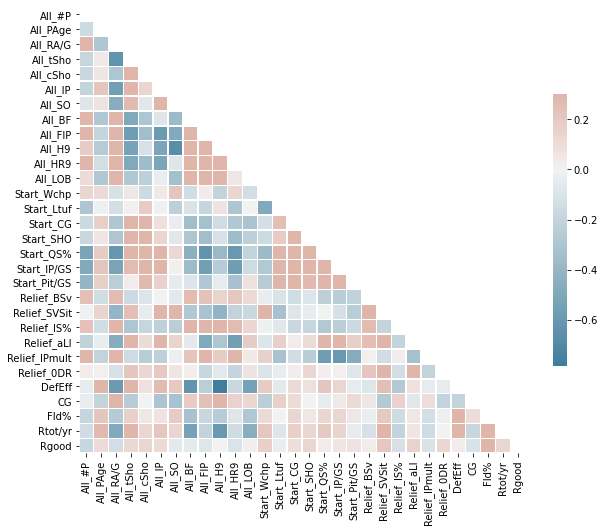

In [116]:
f, ax = plt.subplots(figsize=(10, 10))
corr = Defense.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.savefig('../Images/CorrHeat_Defensive.jpg')

Some of the negative correlations between a starter's game score may be of concern with respect to autocorrel.

### Batting

In [100]:
Base_Batting=pd.read_pickle('../Base DFs/team_batting_years.pkl')
Adv_Batting=pd.read_pickle('../Base DFs/team_AdvBatting_years.pkl')
Batting=pd.concat([Base_Batting,Adv_Batting],axis=1)

In [101]:
Base_Batting.describe()

,#Bat,BatAge,PA,R,H,2B,3B,HR,RBI,SO,BA,OPS+,GDP,LO,Steal Att.,Sacs,Free_Bases
count,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00,150.00
mean,49.51,28.33,37.97,4.38,"1,394.73",1.70,0.18,1.09,4.17,8.03,0.25,96.83,0.75,0.67,0.73,0.47,3.62
std,4.78,1.07,0.58,0.44,66.98,0.15,0.06,0.23,0.42,0.74,0.01,7.36,0.09,0.06,0.20,0.11,0.45
min,39.00,25.40,36.45,3.30,"1,199.00",1.37,0.03,0.59,3.09,6.01,0.23,81.00,0.54,0.07,0.20,0.23,2.74
25%,46.00,27.70,37.49,4.04,"1,349.25",1.59,0.14,0.91,3.85,7.56,0.25,92.00,0.69,0.65,0.61,0.40,3.29
50%,49.00,28.30,37.95,4.35,"1,396.00",1.69,0.18,1.09,4.14,8.03,0.25,96.50,0.75,0.68,0.70,0.47,3.67
75%,52.00,28.90,38.41,4.66,"1,435.75",1.78,0.21,1.28,4.44,8.55,0.26,101.00,0.83,0.70,0.85,0.55,3.94
max,64.00,32.80,39.31,5.53,"1,598.00",2.19,0.35,1.65,5.27,9.84,0.28,123.00,0.99,0.75,1.46,0.72,4.92


In [102]:
Adv_Batting.describe()

,AIR,BAbip,OWn%,BtRuns,PwrSpd
count,150.00,150.00,150.00,150.00,150.00
mean,100.58,0.30,0.50,-24.26,110.84
std,6.28,0.01,0.04,59.53,25.18
min,88.00,0.28,0.41,-151.60,35.30
25%,96.00,0.29,0.47,-66.38,94.08
50%,100.00,0.30,0.50,-26.90,108.10
75%,104.00,0.30,0.53,8.75,126.83
max,123.00,0.33,0.59,200.00,187.30


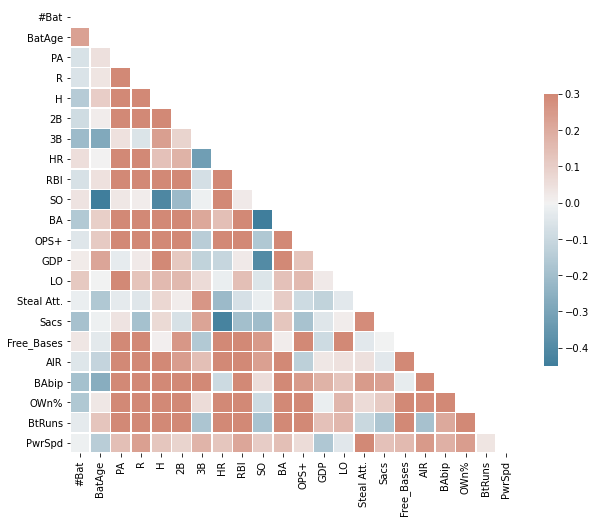

In [106]:
f, ax = plt.subplots(figsize=(10, 10))
corr = Batting.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.savefig('../Images/CorrHeat_Offensive.jpg')

Definetly no autocorrelation to worry about in this case.

## Additional Analysis w/ Game Data
It might be worth looking at info we might glean from the game information 

In [86]:
game_data=pd.read_pickle('../Merged DFs/Games_AllData.pkl')

## Target Variable-Balanced

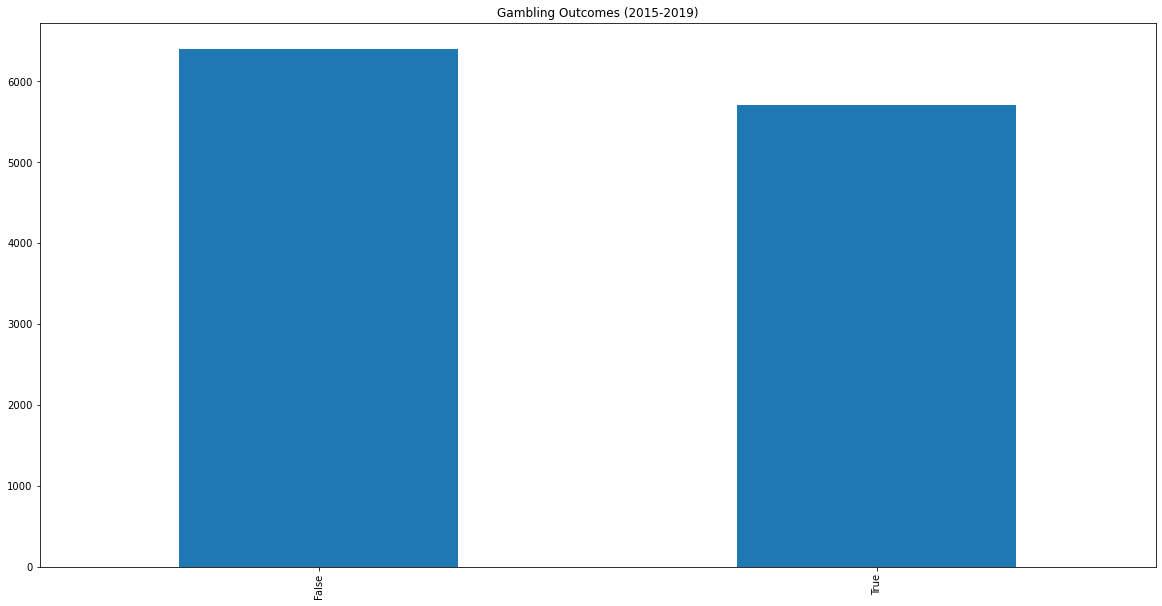

In [115]:
odds_split=game_data.OVER.value_counts()
odds_split
fig,ax=plt.subplots(figsize=(20,10))
ax.set_title('Gambling Outcomes (2015-2019)')
odds_split.plot.bar(ax=ax);
plt.savefig('../Images/Balance_Check.jpg')

Apprears well-balanced.  False outcomes should be more likely since they include observations which neither the over nor under hit.

## Pitching Experience

## Value of O/U Line

In [94]:
by_line=game_data.groupby(['CloseOU']).OVER.agg(['sum','count','mean'])
by_line

,sum,count,mean
CloseOU,,,
5.00,0,1,0.00
5.50,4,8,0.50
6.00,29,69,0.42
6.50,154,275,0.56
7.00,443,999,0.44
7.50,883,1661,0.53
8.00,847,1795,0.47
8.50,1118,2353,0.48
9.00,955,2198,0.43


There is no evidence that the OVER hitting has any relationship to where the line was set.

## By Team &/Or By Time

In [95]:
by_ATeam=game_data.groupby(['Away_Team']).OVER.agg(['sum','count','mean'])
by_HTeam=game_data.groupby(['Home_Team']).OVER.agg(['sum','count','mean'])
by_Team=by_ATeam+by_HTeam
by_Team['mean']=by_Team['sum']/by_Team['count']
by_Team

,sum,count,mean
Away_Team,,,
ARI,387,808,0.48
ATL,392,808,0.49
BAL,376,806,0.47
BOS,400,809,0.49
CHC,363,810,0.45
CHW,375,806,0.47
CIN,391,808,0.48
CLE,366,807,0.45
COL,362,811,0.45


There is no evidence that the oddsmakers have any difficulty setting the line for a particular team over the entire period of observation.

In [112]:
annual_splits=game_data.groupby(['year']).OVER.agg(['sum','count','mean'])
monthly_splits=game_data.groupby(['month']).OVER.agg(['sum','count','mean'])
print(annual_splits)
print(monthly_splits)

       sum  count  mean
year                   
2015  1174   2422  0.48
2016  1151   2420  0.48
2017  1129   2424  0.47
2018  1122   2427  0.46
2019  1136   2423  0.47
        sum  count  mean
month                   
3        42     92  0.46
4       886   1812  0.49
5      1001   2099  0.48
6       956   2020  0.47
7       833   1868  0.45
8      1000   2096  0.48
9       958   2025  0.47
10       36    104  0.35


There is no evidence that oddsmakers struggle with setting the line in any given month.  This is somewhat surprising as one might expect that earlier in the season, it is harder to make proper estimations.

Similarly, there is no evidence that oddsmakers struggled to set proper lines in any particular year. 

In [97]:
Hteams_years=game_data.pivot_table(['OVER'],index=['Home_Team'],columns=['year'],aggfunc='mean')
Ateams_years=game_data.pivot_table(['OVER'],index=['Away_Team'],columns=['year'],aggfunc='mean')
teams_years=(Ateams_years+Hteams_years)/2
teams_years.index.name='Team'
teams_years

OVER                    
year 2015 2016 2017 2018 2019
Team                         
ARI  0.50 0.53 0.45 0.46 0.45
ATL  0.49 0.51 0.49 0.47 0.47
BAL  0.48 0.40 0.50 0.46 0.49
BOS  0.51 0.48 0.44 0.48 0.57
CHC  0.43 0.45 0.46 0.43 0.48
CHW  0.47 0.48 0.45 0.48 0.45
CIN  0.49 0.54 0.52 0.49 0.38
CLE  0.48 0.49 0.39 0.47 0.44
COL  0.51 0.44 0.38 0.41 0.48
DET  0.53 0.49 0.53 0.44 0.42
HOU  0.44 0.46 0.50 0.44 0.43
KCR  0.46 0.46 0.46 0.44 0.50
LAA  0.46 0.43 0.42 0.43 0.48
LAD  0.48 0.43 0.48 0.47 0.48
MIA  0.48 0.49 0.52 0.49 0.46
MIL  0.49 0.46 0.41 0.48 0.43
MIN  0.44 0.58 0.43 0.49 0.49
NYM  0.53 0.46 0.56 0.44 0.47
NYY  0.48 0.43 0.50 0.48 0.52
OAK  0.54 0.44 0.52 0.49 0.44
PHI  0.52 0.47 0.43 0.45 0.45
PIT  0.46 0.54 0.39 0.44 0.57
SDP  0.59 0.50 0.49 0.48 0.45
SEA  0.49 0.48 0.45 0.48 0.52
SFG  0.48 0.46 0.46 0.43 0.49
STL  0.42 0.51 0.51 0.46 0.41
TBR  0.47 0.49 0.48 0.45 0.48
TEX  0.44 0.50 0.46 0.47 0.46
TOR  0.48 0.38 0.46 0.50 0.46
WSN  0.52 0.47 0.43 0.47 0.46

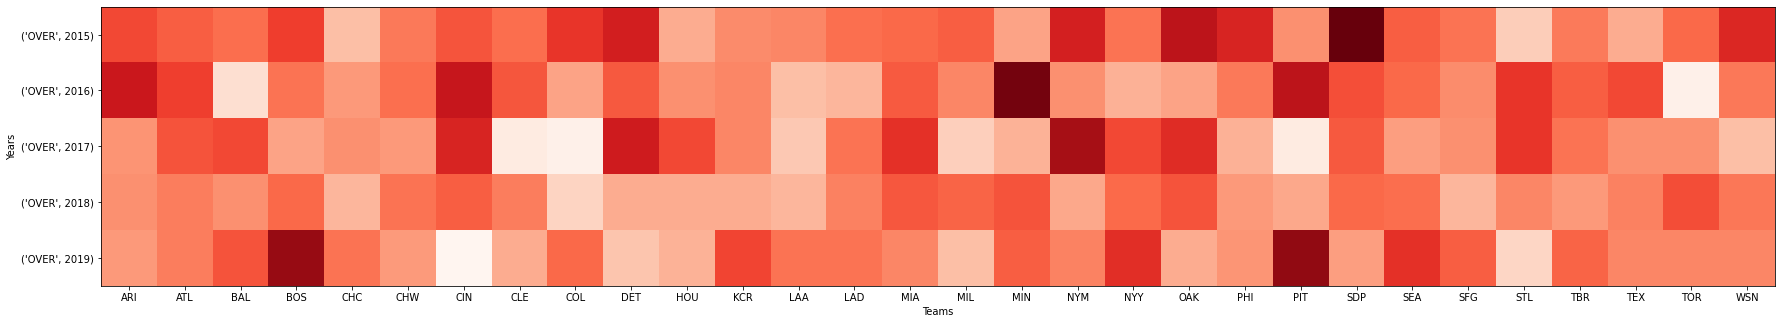

In [114]:
fig,ax=plt.subplots(figsize=(30,30))
indX=np.arange(teams_years.shape[0])
indY=np.arange(teams_years.shape[1])
im=ax.imshow(teams_years.transpose(),cmap='Reds')
ax.set_xlabel('Teams');
ax.set_ylabel('Years');
ax.set_xticks(indX);
ax.set_yticks(indY);
ax.set_yticklabels(teams_years.columns);
ax.set_xticklabels(teams_years.index);
plt.savefig('../Images/Overs_by_TeamYear.jpg')

In [154]:
away_monthly_splits=game_data.groupby(['Away_Team','year','month'])['OVER'].mean()
home_monthly_splits=game_data.groupby(['Home_Team','year','month'])['OVER'].mean()
away_monthly_splits.index.names=['Team','year','month']
home_monthly_splits.index.names=['Team','year','month']
monthly_team_splits=(away_monthly_splits+home_monthly_splits)/2
monthly_pivot=monthly_team_splits.unstack().unstack().swaplevel('month','year',axis=1)
monthly_pivot=monthly_pivot.sort_index(axis=1,level=0).dropna(axis=1)

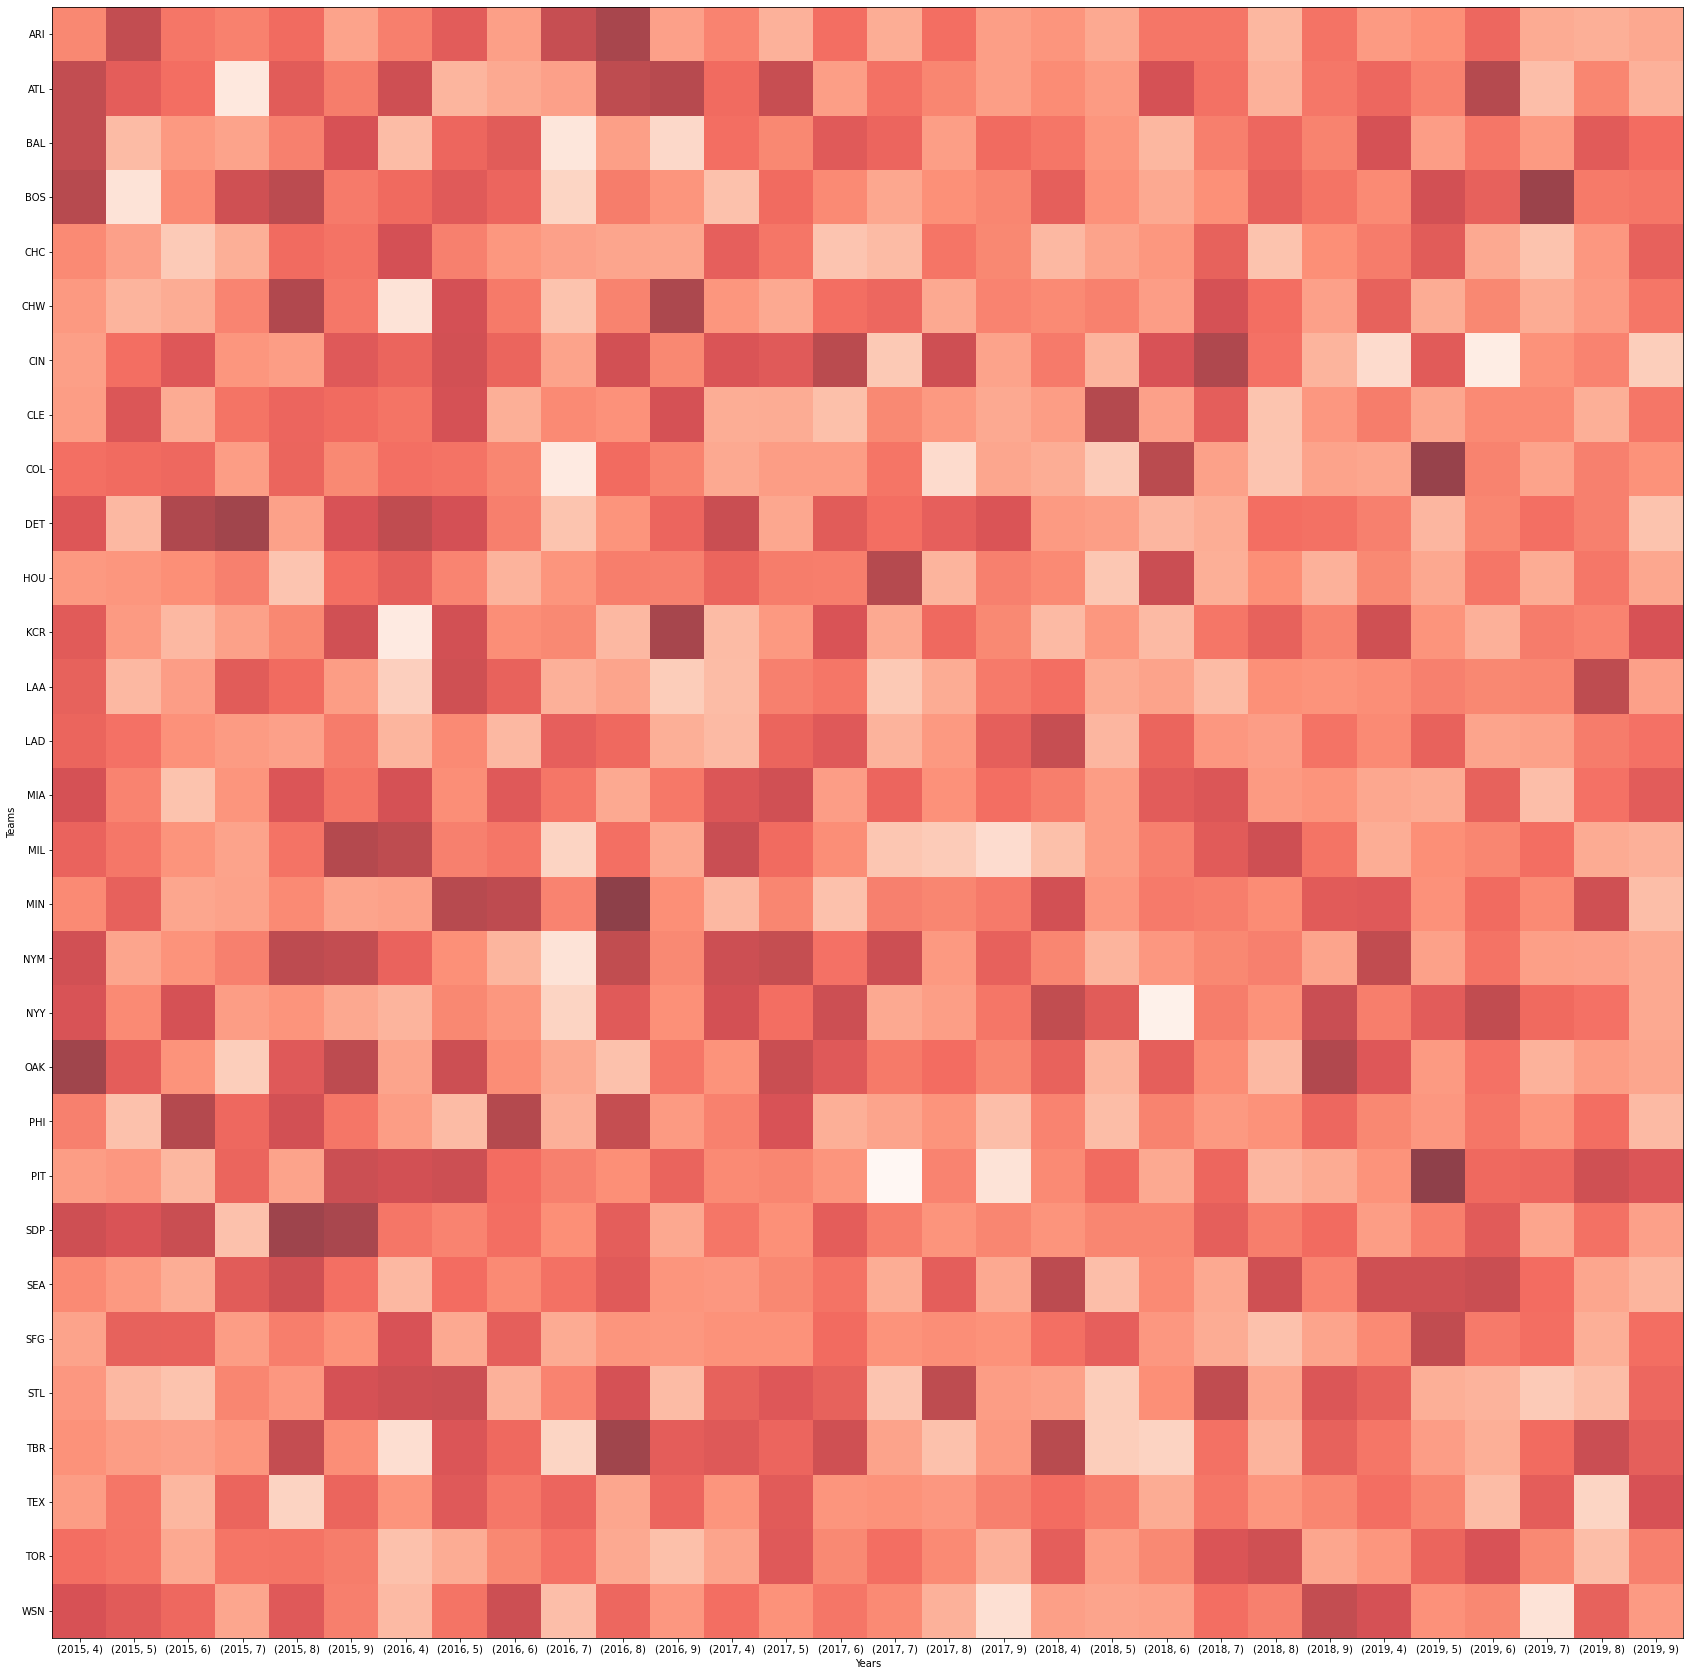

In [156]:
fig,ax=plt.subplots(figsize=(30,30))
indX=np.arange(monthly_pivot.shape[1])
indY=np.arange(monthly_pivot.shape[0])
im=ax.imshow(monthly_pivot,cmap='Reds',alpha=0.75)
ax.set_ylabel('Teams');
ax.set_xlabel('Years');
ax.set_xticks(indX);
ax.set_yticks(indY);
ax.set_xticklabels(monthly_pivot.columns);
ax.set_yticklabels(monthly_pivot.index);
plt.savefig('../Images/Overs_by_TeamMonth.jpg')

The heatmaps above suggest that over a single year or given month (or other short-term period) that oddsmakers struggle to properly set the line for a specific team.

# Modeling

## Initial Setup

In [164]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

## Prep Data for Training

In [160]:
dataset=pd.read_pickle('../Merged Dfs/Final_Database.pkl')
X=dataset.drop('OVER',axis=1)
y=dataset.OVER
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1988)

In [161]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=pd.DataFrame(scaler.transform(X_train),columns=X_train.columns,index=X_train.index)
X_test=pd.DataFrame(scaler.transform(X_test),columns=X_test.columns,index=X_test.index)

## Train Models

### Logistic Regression

#### Simple w/ Cross Validation

In [165]:
if (__MODELS_TRAINED__&__DATA_COLLECTED__):
    with open('../Models/SimpleCV_Log.pkl','rb') as f:
        CV_log_model=pickle.load(f)
    pass
else:
    CV_log_results=ModelWithCV(LogisticRegression(random_state=1988,max_iter=1000),'simple_log',X_train,y_train)
    CV_log_model=CV_log_results.model
    CV_log_model.fit(X_train,y_train)
    with open('../Models/SimpleCV_Log.pkl','wb') as f:
        pickle.dump(CV_log_model,f)
    pass

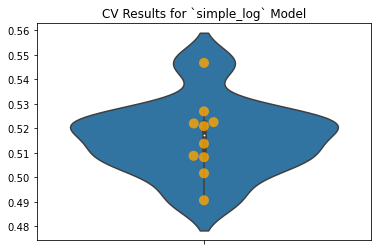

In [166]:
fig,ax=plt.subplots()
ax=CV_log_results.plot_cv(ax)
plt.plot();
plt.savefig('../Images/SimpleCVLog-Results.jpg')

In [402]:
pprint.pprint(dict(zip(X_train.columns.values,np.round(CV_log_model.coef_[0],2))))

{'#Bat_A': 0.05,
 '#Bat_H': -0.0,
 '2B_A': 0.07,
 '2B_H': 0.09,
 '3B_A': 0.06,
 '3B_H': 0.09,
 'AB_A': 0.39,
 'AB_H': -0.45,
 'AIR_A': -0.2,
 'AIR_H': -0.23,
 'All_#P_A': -0.01,
 'All_#P_H': -0.06,
 'All_BF_A': -0.22,
 'All_BF_H': -0.66,
 'All_FIP_A': 0.15,
 'All_FIP_H': 0.52,
 'All_H9_A': -0.01,
 'All_H9_H': 0.03,
 'All_HR9_A': -0.1,
 'All_HR9_H': -0.13,
 'All_IP_A': 0.09,
 'All_IP_H': 0.26,
 'All_LOB_A': 0.11,
 'All_LOB_H': 0.24,
 'All_PAge_A': -0.01,
 'All_PAge_H': 0.03,
 'All_RA/G_A': 0.05,
 'All_RA/G_H': 0.17,
 'All_SO/W_A': 0.03,
 'All_SO/W_H': -0.03,
 'All_SO_A': 0.07,
 'All_SO_H': 0.0,
 'All_cSho_A': 0.01,
 'All_cSho_H': 0.01,
 'All_tSho_A': 0.02,
 'All_tSho_H': -0.01,
 'BA_A': 0.35,
 'BA_H': 0.12,
 'BAbip_A': -0.39,
 'BAbip_H': -0.61,
 'BatAge_A': 0.04,
 'BatAge_H': 0.0,
 'BtRuns_A': -0.51,
 'BtRuns_H': 0.63,
 'CG_A': 0.04,
 'CG_H': 0.03,
 'CloseOU': -0.1,
 'DefEff_A': -0.09,
 'DefEff_H': -0.18,
 'Fld%_A': 0.01,
 'Fld%_H': -0.02,
 'Free_Bases_A': 0.58,
 'Free_Bases_H': -0.11,


              precision    recall  f1-score   support

       False       0.53      0.70      0.60      1589
        True       0.48      0.31      0.37      1440

    accuracy                           0.52      3029
   macro avg       0.51      0.51      0.49      3029
weighted avg       0.51      0.52      0.49      3029



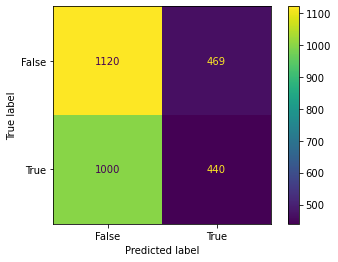

In [167]:
plot_confusion_matrix(CV_log_model,X_test,y_test);
plt.savefig('../Images/SimpleCVLog-Confusion.jpg')
print(classification_report(y_test,CV_log_model.predict(X_test)))

The logistic model is somehow even worse than just a dummy guessing all False. It is also noteworthy that the  majority of the accuracy is coming from correctly guessing False observations.  This imbalance may be a detriment to a gambler who may be only concerned with the outcome when the bets (i.e. when the model predicts True and might suffer from too many false negativeese, even if it benefits the model's accuracy.

#### Grid Search

In [168]:
param_grid={
    'max_iter':[500,1000,1500,5000],
    'penalty':['l1','l2','none'],
    'solver':['liblinear','lbfgs'],
}

In [169]:
grid_logistic=GridSearchCV(LogisticRegression(random_state=1988),param_grid,cv=5,scoring='accuracy',verbose=1,n_jobs=-1)

In [170]:
if (__MODELS_TRAINED__&__DATA_COLLECTED__):
    with open('../Models/Grid_Log.pkl','rb') as f:
        grid_logistic_model=pickle.load(f)
    pass
else:
    grid_logistic.fit(X_train,y_train)
    grid_logistic_model=grid_logistic.best_estimator_
    with open('../Models/Grid_Log.pkl','wb') as f:
        pickle.dump(grid_logistic_model,f)
    pass

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.6min finished


In [171]:
print(grid_logistic.best_score_)
print(grid_logistic.best_params_)

0.5166735385701475
{'max_iter': 1000, 'penalty': 'none', 'solver': 'lbfgs'}


By getting rid of the regularization (penalty parameter set to None), we improve--but only slightly--the model's performance on the training data.

What do the coefficients look like?

In [172]:
pprint.pprint(dict(zip(X_train.columns.values,np.round(grid_logistic_model.coef_[0],2))))

{'#Bat_A': 0.05,
 '#Bat_H': 0.0,
 '2B_A': 0.12,
 '2B_H': 0.02,
 '3B_A': 0.07,
 '3B_H': 0.05,
 'AIR_A': -0.44,
 'AIR_H': 0.1,
 'All_#P_A': -0.02,
 'All_#P_H': -0.05,
 'All_BF_A': -1.45,
 'All_BF_H': -4.09,
 'All_FIP_A': 0.14,
 'All_FIP_H': 0.55,
 'All_H9_A': -0.06,
 'All_H9_H': 0.06,
 'All_HR9_A': -0.07,
 'All_HR9_H': -0.14,
 'All_IP_A': 0.57,
 'All_IP_H': 1.51,
 'All_LOB_A': 0.73,
 'All_LOB_H': 1.95,
 'All_PAge_A': 0.0,
 'All_PAge_H': 0.02,
 'All_RA/G_A': 1.03,
 'All_RA/G_H': 2.75,
 'All_SO_A': 0.03,
 'All_SO_H': 0.05,
 'All_cSho_A': 0.01,
 'All_cSho_H': 0.01,
 'All_tSho_A': 0.03,
 'All_tSho_H': 0.0,
 'BA_A': -0.06,
 'BA_H': 0.14,
 'BAbip_A': -0.52,
 'BAbip_H': -0.73,
 'BatAge_A': 0.04,
 'BatAge_H': -0.0,
 'BtRuns_A': -0.96,
 'BtRuns_H': 1.14,
 'CG_A': 0.05,
 'CG_H': 0.02,
 'CloseOU': -0.11,
 'DefEff_A': -0.15,
 'DefEff_H': -0.14,
 'Fld%_A': 0.02,
 'Fld%_H': -0.03,
 'Free_Bases_A': 0.6,
 'Free_Bases_H': 0.06,
 'GDP_A': -0.04,
 'GDP_H': 0.01,
 'HR_A': -0.01,
 'HR_H': -0.26,
 'H_A': 1.26

              precision    recall  f1-score   support

       False       0.53      0.69      0.60      1589
        True       0.49      0.32      0.39      1440

    accuracy                           0.52      3029
   macro avg       0.51      0.51      0.49      3029
weighted avg       0.51      0.52      0.50      3029



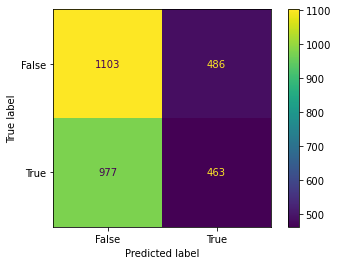

In [173]:
print(classification_report(y_test,grid_logistic_model.predict(X_test)))
plot_confusion_matrix(grid_logistic_model,X_test,y_test);
plt.savefig('../Images/GridLog-Confusion.jpg')

### Random Forest

In [404]:
param_grid = { 
    'n_estimators': [300,400,500,600,700,800],
    'min_samples_leaf':[25,50,75,80,90],
    'max_leaf_nodes':range(50,100,5),
    'max_features' :['auto', 5,6]
}

In [405]:
grid_forest=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [407]:
if (__MODELS_TRAINED__&__DATA_COLLECTED__):
    with open('../Models/Grid_Log.pkl','rb') as f:
        grid_forest_model=pickle.load(f)
    pass
else:
    grid_forest.fit(X_train,y_train)
    grid_logistic_model=grid_logistic.best_estimator_
    with open('../Models/Grid_Forest.pkl','wb') as f:
        pickle.dump(grid_lforest_model,f)
    pass


Fitting 5 folds for each of 900 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 23.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 42.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 66.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 89.4min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 110.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 135.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 165.5min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed: 182.5min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': ['auto', 5, 6],
                         'max_leaf_nodes': range(50, 100, 5),
                         'min_samples_leaf': [25, 50, 75, 80, 90],
                         'n_estimators': [300, 400, 500, 600, 700, 800]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_forest_model.score(X_test,y_test)
print(classification_report(y_test,grid_forest_model.predict(X_test)))
plot_confusion_matrix(grid_forest_model,X_test,y_test);
plt.savefig('../Images/Forest-Confusion.jpg')

In [175]:
pprint.pprint(dict(zip(X_test.columns,grid_forest_model.feature_importances_)))

{'#Bat_A': 0.008772766589135048,
 '#Bat_H': 0.0053278449323147705,
 '2B_A': 0.01010743791856066,
 '2B_H': 0.0108974452362617,
 '3B_A': 0.009548752228716685,
 '3B_H': 0.011710132351576481,
 'AIR_A': 0.011581759207467903,
 'AIR_H': 0.007509543100647016,
 'All_#P_A': 0.005550056912706601,
 'All_#P_H': 0.00843307217775191,
 'All_BF_A': 0.010657201118375339,
 'All_BF_H': 0.006763314545489442,
 'All_FIP_A': 0.011957433937879312,
 'All_FIP_H': 0.002784565393208734,
 'All_H9_A': 0.008894069082619409,
 'All_H9_H': 0.01207851730002184,
 'All_HR9_A': 0.004782416723031912,
 'All_HR9_H': 0.01130479345673314,
 'All_IP_A': 0.009586190933917898,
 'All_IP_H': 0.009343615266451383,
 'All_LOB_A': 0.011774754042182398,
 'All_LOB_H': 0.010888535962572799,
 'All_PAge_A': 0.007780398723140299,
 'All_PAge_H': 0.010062450339605193,
 'All_RA/G_A': 0.010106459869155919,
 'All_RA/G_H': 0.011938208465969987,
 'All_SO_A': 0.012994754335460998,
 'All_SO_H': 0.009923212070707121,
 'All_cSho_A': 0.0026908213188208082,

In [176]:
grid_forest_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 5,
 'max_leaf_nodes': 50,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 80,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 700,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [179]:
#Lets look @ an example tree
example_tree=grid_forest_model.estimators_[5]
export_graphviz(example_tree,out_file='../Images/tree_example.dot')